In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [2]:
summ = pd.read_csv('summtab.csv')

In [3]:
cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [4]:
allcross = vstack(cross,cross2)

In [5]:
allcross[:6]

<Table length=6>
src_n   Porb  ...                       OIV V                        Part
int64 float64 ...                       str49                       int64
----- ------- ... ------------------------------------------------- -----
    2    84.0 ...                                                --     1
    3   18.38 ...    smc_list/OGLE-IV/V/CALIBRATED/smc720.17.19.dat     1
    4   82.37 ... smc_list/OGLE-IV/V/CALIBRATED/smc718.01.21607.dat     1
    5      -- ... smc_list/OGLE-IV/V/CALIBRATED/smc719.21.39743.dat     1
    6    17.2 ...   smc_list/OGLE-IV/V/CALIBRATED/smc719.18.340.dat     1
    7    21.9 ...    smc_list/OGLE-IV/V/CALIBRATED/smc726.29.19.dat     1

# Superorbital Characterization
- sometimes there seem to be distinct categories, but better to identify features and sources can have multiple
    - still worth singling out a couple categories that really seem alike and apart from the others
- see document with by-eye categorization to help quantify features

- continue with other outlined features and optimize existing ones

# color-mag slope when bright vs. faint
- divide I range in two and fit line
- is one clearly steeper than the other?
- can also try comparing correlation coefficients


In [6]:
def div_cm(srcn,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece'''
    #get LCs within function 
    if len(interp)==0:
        #check which part to determine mlist
        row = cross[cross['src_n']==srcn]
        if row['Part']==2:
            mlist = ['OII I','OIII I','OIV I']
        else: 
            mlist = ['OII I','OIII I']
        iband, vband = o.getIV(srcn,cross,stack=True,mlist=mlist,radec=False)
        interp = o.colormag(iband,vband,plot=False)
    #add interpolated I to V table
    vband['I int'] = interp
    #divide into two using interp range
    irange = np.max(interp)-np.min(interp)
    split = np.max(interp) - irange*frac
    #lower interp
    vbright = vband[vband['I int']<=split]
    vfaint = vband[vband['I int']>=split]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]): print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]): print('steeper when brighter')
        #returns faint then bright slope
        return fmod[0],bmod[0]
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777


((0.5565777219184822, -0.7817142502368777),
 (0.923357633786783, -2.1097143664210405))

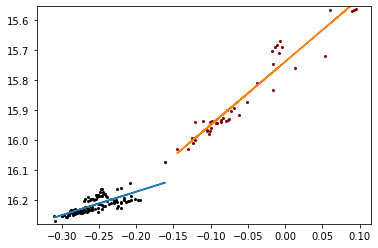

In [8]:
# comparison of correlation coefficients works well only if fraction low, etc.
div_cm(55,plot=True,frac=0.3,findcorr=True)

#### for all sources in first category; don't use $r^2$

In [9]:
#source numbers for part 1 and 2
p1n = cross['src_n']
p2n = cross2['src_n']

In [10]:
reload(o)
for s in [55,15,48,128,132]:
    if s in p1n:c = cross
    else: c = cross2
    print(div_cm(s,plot=False,frac=0.3,cross=c)) #prints slopes

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
steeper when brighter
(-0.7817142502368777, -2.1097143664210405)
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
steeper when brighter
(-1.414901384568145, -1.721822626558221)
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
steeper when brighter
(-0.5373189569373191, -2.071339432112716)
I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
steeper when brighter
(-1.8257551315917082, -1.9894361407400687)
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
steeper when brighter
(-0.8301604164589212, -2.1829490626005708)


In [284]:
nums = cross['src_n']

In [12]:
#now for a few sources not in the group
for s in nums[:5]: #the other ones are part 2; can do later
    print(div_cm(s,plot=False,frac=0.3))

I and V-I correlation: -0.9846799925699677
V and V-I correlation: -0.9546678612457401
steeper when brighter
(-1.8726433827108229, -2.785861846153874)
I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
steeper when fainter
(-1.7351281369546334, -1.37878276183988)
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
steeper when fainter
(-0.9113626805486055, -0.40648367934272983)
I and V-I correlation: -0.6677821537439047
V and V-I correlation: 0.17975703286765632
steeper when brighter
(-0.10783272462329767, -0.6362910453747979)
I and V-I correlation: -0.7854401757019701
V and V-I correlation: -0.44726007362846626
steeper when brighter
(-0.5788820480420496, -2.5619734890500827)


can be used as one needed characteristic for this category but not going to distinguish being in/out of the group

# is there a base state?
- try to make three categories: 'normal' state at brightest, at faintest, and no 'normal' state (continuous variation)

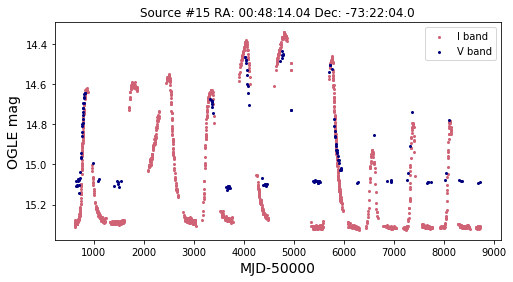

In [13]:
#how many points within some range from brightest vs. faintest point
#maybe check that they occur in every epoch?
iband,vband = o.getIV(15,cross,stack=True,plot=True)

In [130]:
len(cross2)

51

In [15]:
def findbase(srcn,cross=cross,iband=[],vband=[],plot=True,cut=100,diff=0.1,frac=False,printall=False,perc=0,checkog=True):
    '''percentile used instead of maximum and minimum; must be greater than 50
    if frac: use diff as fraction of range rather than magnitudes
    checkog: check that base points are in all OGLE epochs '''
    if len(iband)==0:
        #identify if part2
        if len(cross)==51: mlist = ['OII I','OIII I','OIV I']
        else: mlist = ['OII I','OIII I']
        ilist,vlist = o.getIV(srcn,cross,stack=False,plot=plot,mlist=mlist)
        iband,vband = vstack(ilist),vstack(vlist)
    #identify minimum and maximum points
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if frac:
        #window for points near max or min is fraction of range
        #if overall low variability, window smaller
        diff = (maxi-mini)*diff
    if perc>0:
        maxi = np.median(iband['I mag'])+scipy.stats.iqr(iband['I mag'], rng=[50,perc])
        mini = np.median(iband['I mag'])-scipy.stats.iqr(iband['I mag'], rng=[(100-perc),50])
    #filter table to points within 0.1 mags (to do: or do fractional?) of max and min
    minf = iband[iband['I mag']<=mini+diff]
    maxf = iband[iband['I mag']>=maxi-diff]
    
    if len(maxf)>len(minf)+cut:
        #make sure maximum points exist in all OGLE epochs
        go = True
        if checkog: 
            for i in ilist:
                tmaxf = i[i['I mag']>=maxi-diff]
                #in no points in an epoch, sets to undetermined
                if len(tmaxf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at faintest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at faintest')
            return 'base at faintest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    elif len(minf)>len(maxf)+cut:
        go = True
        if checkog: 
            for i in ilist:
                tminf = i[i['I mag']<=mini+diff]
                #in no points in an epoch, sets to undetermined
                if len(tminf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at brightest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at brightest')
            return 'base at brightest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    else: 
        if printall: print(f'{srcn}: undetermined or no base')
        elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
        return 'undetermined or no base'

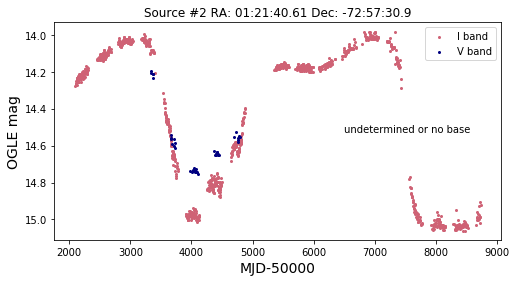

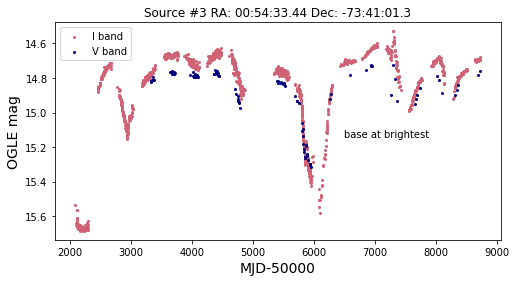

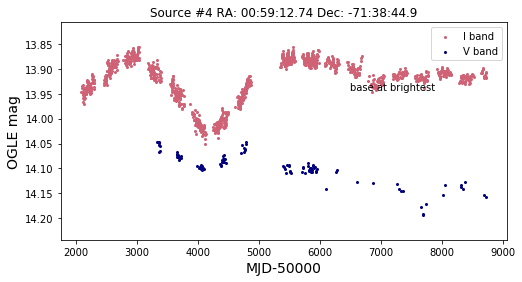

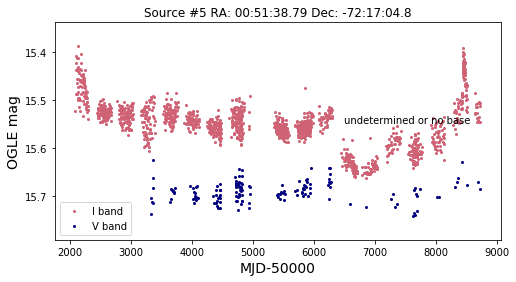

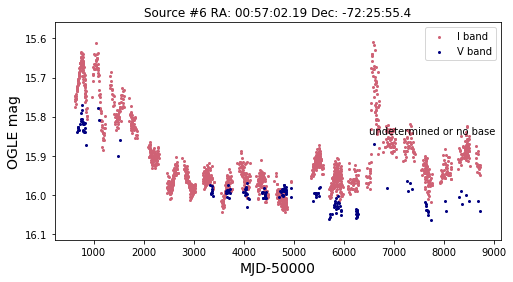

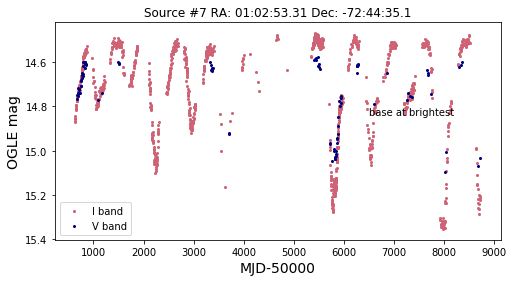

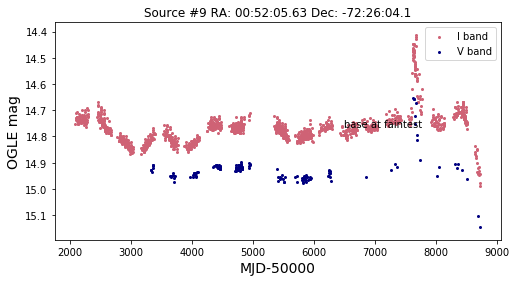

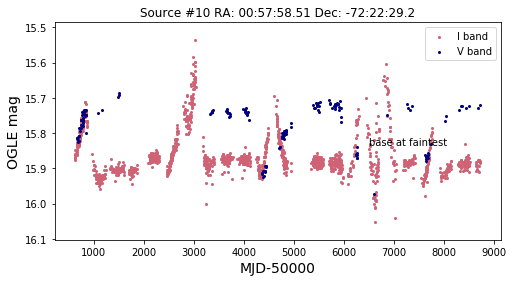

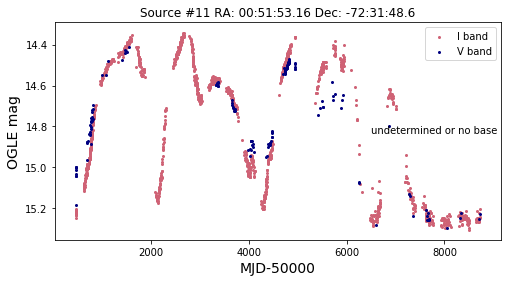

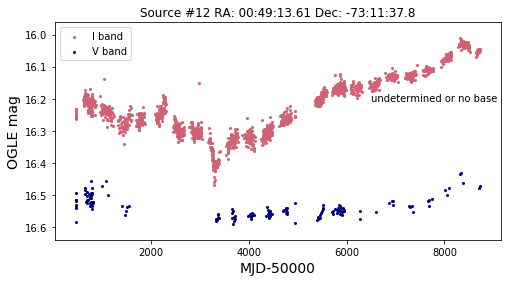

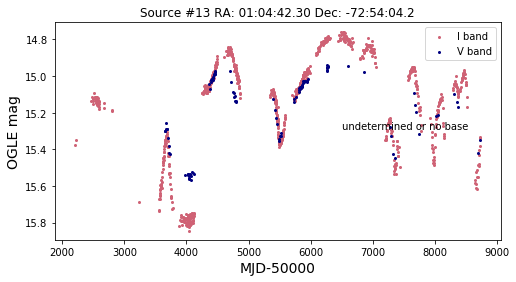

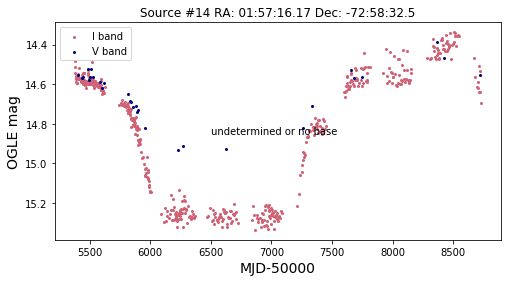

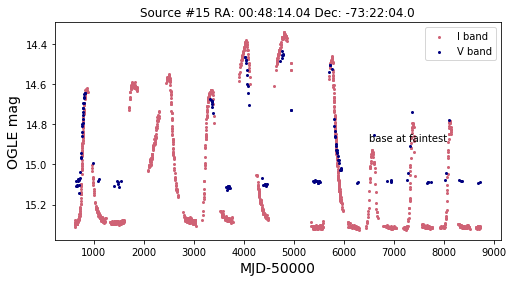

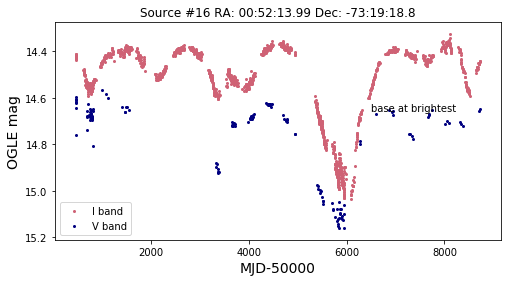

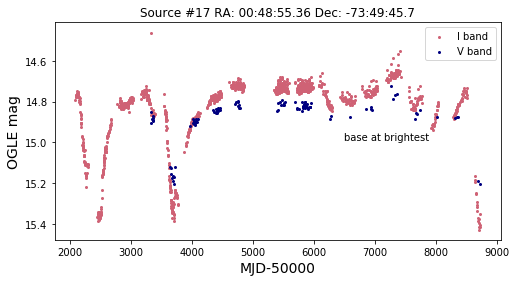

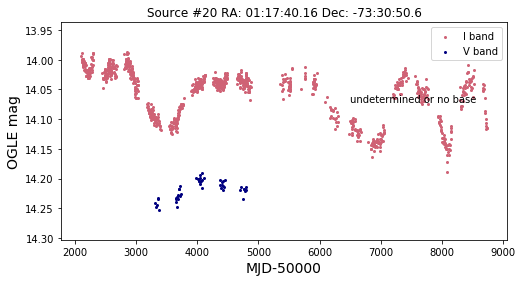

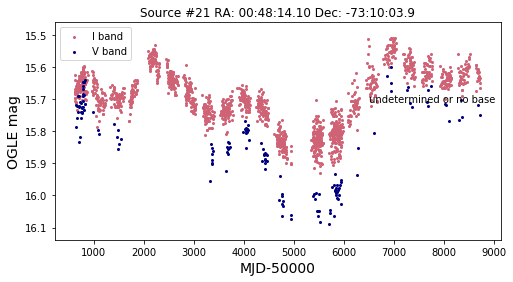

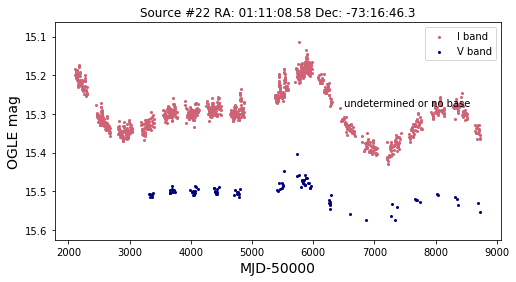

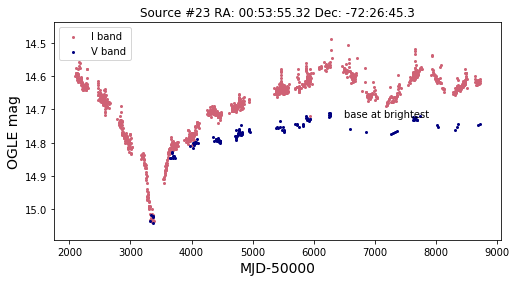

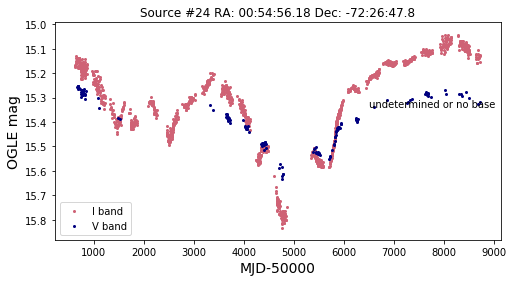

In [285]:
#happy with basically all of these
for s in nums[:20]:
    findbase(s,perc=95,cut=200,frac=True)
plt.savefig('Figs/bases.png',dpi=200,bbox_inches='tight')

perhaps the max/min that 'fails' the test needs to be distributed in all epochs s.t. a very long-term trend doesn't justify a base determination

empty file for OIII I


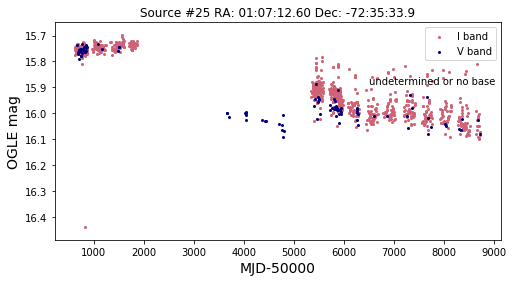

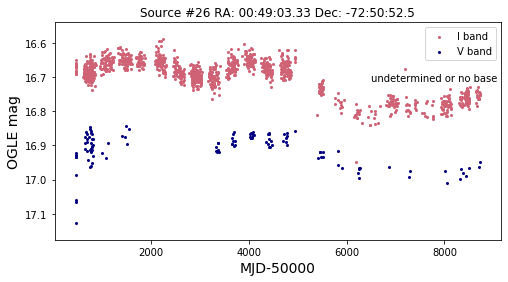

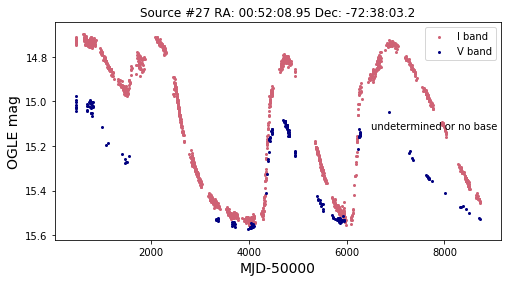

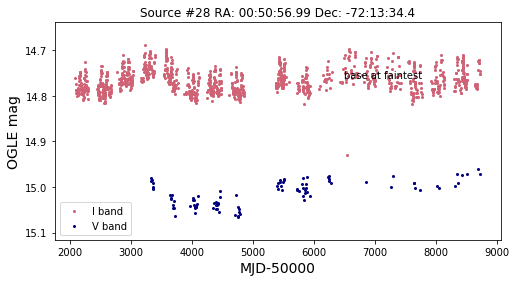

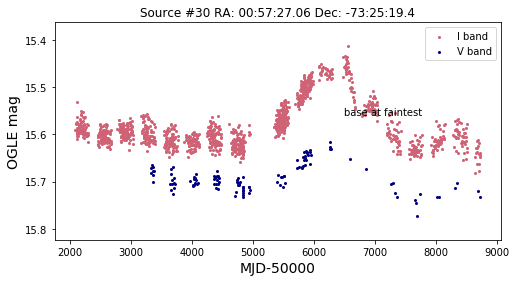

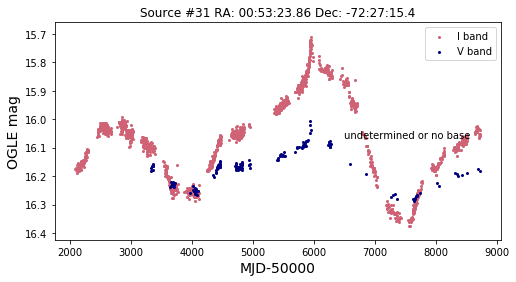

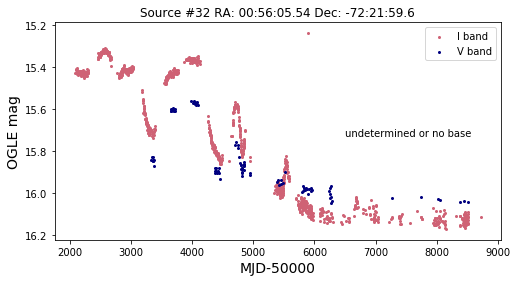

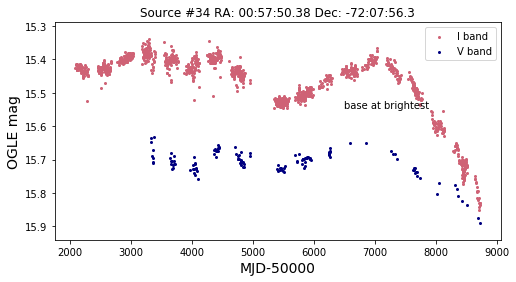

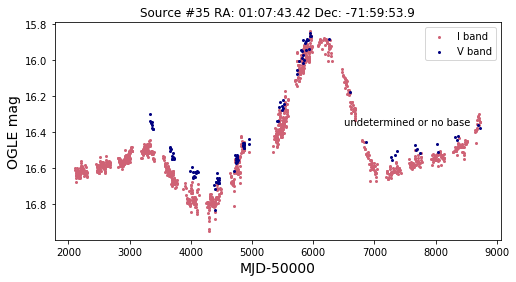

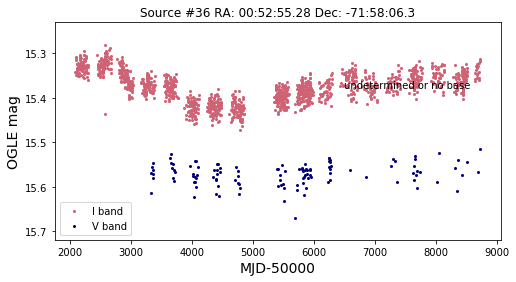

In [17]:
for s in nums[20:30]:
    findbase(s,perc=95,cut=200,frac=True,checkog=True)

# shape of flare
- compare width to height
- triangular?
    - width within some fraction of flare?
- **as a side task, work on also getting peak width of periodogram**

In [18]:
iband,vband = o.getIV(15,cross,stack=True,plot=False)

In [19]:
def peaks(iband,bright=True,window=100,btol=100,height=0.1,distance=30,plot=True,frac=0.3,spline=True):
    '''Use spline to find peaks (or troughs) in I band data
    bright: (bool) look for brightness peaks (so magnitude minima)
    TO DO: generalize to troughs
    spline: uses spline trend to find peaks rather than original data
    TO DO: condition to no longer use spline if peaks very different from data min/max'''
    flatten,trend = o.splinedetrend(iband,window=window,btol=btol,retspline=True)
    if bright and spline: diff = np.max(trend) - trend
    elif bright: diff = np.max(iband['I mag']) - iband['I mag']
    else: diff = trend
    peaks = signal.find_peaks(diff,height=height,distance=distance) 
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if plot:
        plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
        plt.ylim(maxi+.01,mini-.01)
    peakmag = iband['I mag'][peaks[0]]
    cut = maxi-(maxi-mini)*frac
    inds = np.where(peakmag<cut)[0]
    minpeaks = peakmag[inds]
    minloc = peaks[0][inds]
    if plot:
        plt.scatter(iband['MJD-50000'][peaks[0]],iband['I mag'][peaks[0]],label='deleted peaks')
        plt.scatter(iband['MJD-50000'][minloc],minpeaks,color='darkseagreen',label='kept peaks')
        plt.plot(iband['MJD-50000'],trend,color='black',alpha=0.3,label='spline')
        plt.legend()
    #decide what to return
    return trend,minloc #returns indices in iband of peaks

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

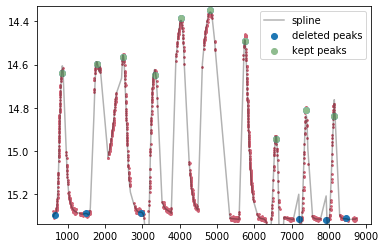

In [20]:
trend,minloc = peaks(iband)
minloc

#### peak widths
 - peak heights are not a reliable help

calculate peak heights using 95th percentile of window between peaks

In [21]:
def peakwidth(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True,fs=(5,4),text=False,split=0.7,spline=False,wmin=50):
    '''find width of peak at some fraction of range (default: FWHM)
    bounds of peak can be passed in or found using...
    pinds: indices of peaks in iband
    bounds: (bool) use pinds as start and end dates of peaks rather than locs of peaks
    retheight: return height of peak as well'''
    #if bounds, pinds are start and end dates of peak
    if bounds:
        df = iband[iband['MJD-50000']>=pinds[0]]
        df = iband[iband['MJD-50000']<=pinds[1]]
    else:
        plocs = np.array(iband['MJD-50000'][pinds])
        df = iband[iband['MJD-50000']<plocs[0]+(plocs[1]-plocs[0])*split]
        len1 = len(df)
        df = df[df['MJD-50000']>plocs[0]-(plocs[1]-plocs[0])/2]
        len2 = len(df)
    if plot: 
        plt.figure(figsize=fs)
        plt.scatter(df['MJD-50000'],df['I mag'],color=pink)
        maxi,mini = np.max(df['I mag']),np.min(df['I mag'])
        plt.ylim(maxi+.02,mini-.02)
    #start ind 
    st = len1-len2
    end = len(df)+st
    half = np.min(df['I mag']) + (np.max(df['I mag']) - np.min(df['I mag']))*frac
    if plot:
        if spline: plt.plot(df['MJD-50000'],trend[st:end],color=pink)
        #draw line at half max or other fraction of range
        plt.axhline(half,color='grey')
    #interpolate spline for even coverage
    x = np.arange(df['MJD-50000'][0],df['MJD-50000'][-1])
    if spline: interp = np.interp(x,df['MJD-50000'],trend[st:end])
    else: interp = np.interp(x,df['MJD-50000'],df['I mag'])
    #find intersection of line and interpolated spline
    idx = np.argwhere(np.diff(np.sign(interp - half))).flatten()
    #find peak height
    height = np.max(df['I mag'])-np.min(df['I mag'])
    if len(idx)<2: #does not succesfully find two solutions
        if retheight: return np.nan,height
        else: return np.nan
    else: width = x[idx[1]]-x[idx[0]]
    #replace width if multple points before other side
    c = 2
    while width<wmin and len(idx)>c:
        width = x[idx[c]]-x[idx[0]]
        c+=1
    if width<wmin and retheight: return np.nan,height
    elif width< wmin: return np.nan
    if plot: 
        plt.scatter(x[idx], interp[idx], color='darkseagreen')
        lenx = len(x)
        if text: plt.text(x[idx[0]],np.max(iband['I mag'])-.04,f'width at {frac} of peak: {width:.2f} days')
        plt.ylabel('I mag',fontsize=14)
        plt.xlabel('MJD-50000',fontsize=14)
    if retheight: return width,height
    else: return width

In [22]:
def allwidths(iband,trend,pinds,frac=0.5,bounds=False,plot=True,retheight=True,wmin=50):
    '''loop through all peaks and calculate widths and heights
    TO DO: plot on subplots'''
    widths,heights = [],[]
    #final bound is last point of iband
    end = len(iband)-1
    pinds = np.concatenate([pinds,[end]])
    for p in range(len(pinds)-1):
        #get width and height of peak
        w,h = peakwidth(iband,trend,[pinds[p],pinds[p+1]],frac=frac,wmin=wmin,bounds=bounds,plot=plot,retheight=retheight)
        widths.append(w)
        heights.append(h)
    return widths, heights

In [23]:
minloc

array([ 143,  315,  425,  668,  792,  946, 1112, 1348, 1460, 1569])

[188.0,
 375.0,
 414.0,
 230.0,
 334.99999999999955,
 539.0,
 194.0,
 126.0,
 104.0,
 132.0]

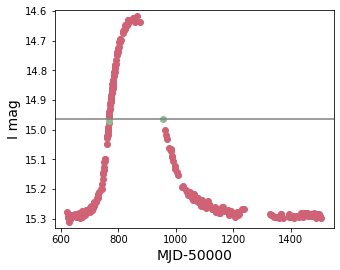

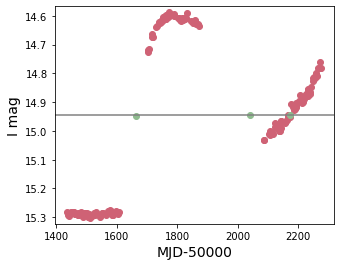

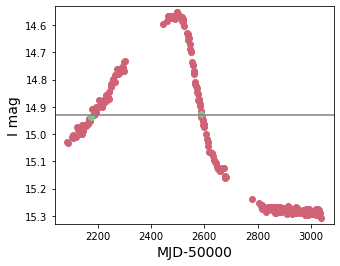

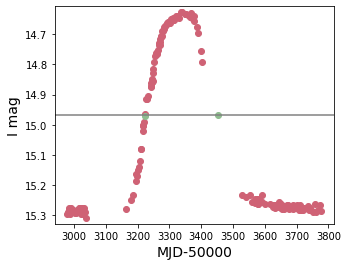

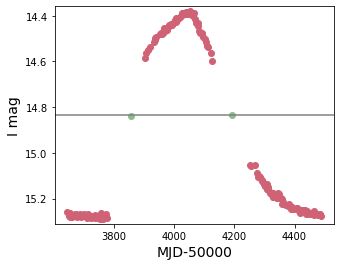

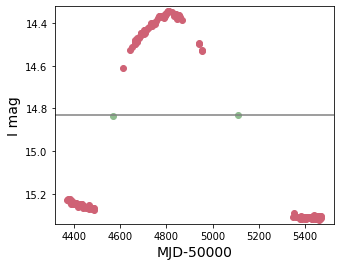

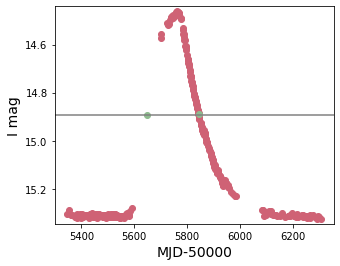

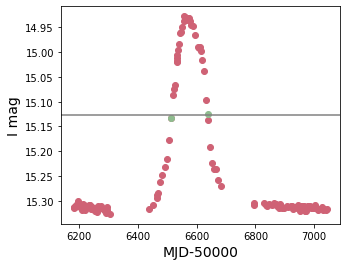

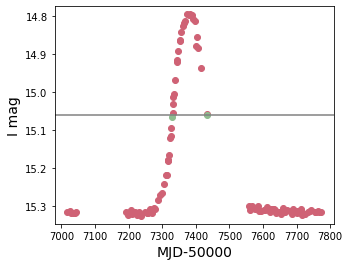

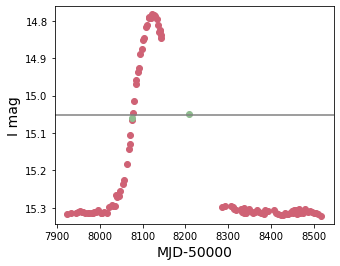

In [24]:
ws,hs = allwidths(iband,trend,minloc)
ws

In [25]:
#variation of peak distances -- compare these to widths
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([925.17414, 702.15882, 843.66484, 707.11579, 787.95173, 919.30032,
       837.72239, 807.90837, 751.9861 ])

Text(0.5, 0, 'Peak Width (days)')

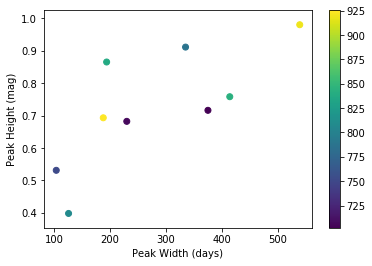

In [26]:
#relationship between FWHM and height
#color is distance between flare peak and previous flare peak
plt.scatter(ws[:-1],hs[:-1],c=seps)
plt.colorbar()
plt.ylabel('Peak Height (mag)')
plt.xlabel('Peak Width (days)')

goals with flare shape
- make similar plots to one above
- help with categorization
    - e.g. use ratio of width and height

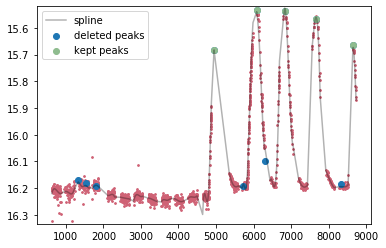

In [27]:
#repeat for others of this type
iband,vband = o.getIV(55,cross,stack=True,plot=False)
trend,minloc = peaks(iband)

In [28]:
ws,hs = allwidths(iband,trend,minloc[:-1],plot=False) #couldn't do final flare since it doesn't reach half max

In [29]:
ws

[351.0, 308.0, 298.0, 277.0]

In [30]:
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
seps

array([1135.99572,  746.00591,  832.80413,  988.21437])

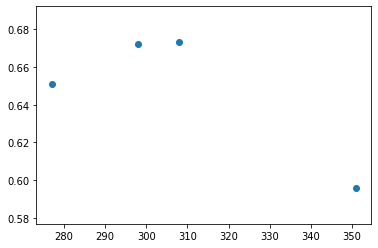

In [31]:
plt.scatter(ws,hs) #interesting but tough when sampling so uneven in first peak

Text(0.5, 0, 'Widths')

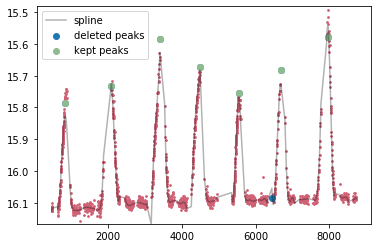

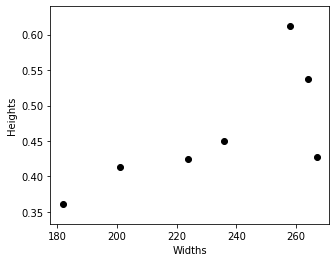

In [32]:
iband,vband = o.getIV(48,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')

#### part 2 sources in this category
- returns nan width if two solutions not identified

[1109.02151  929.70401  991.00405 1199.94623 1281.38015]


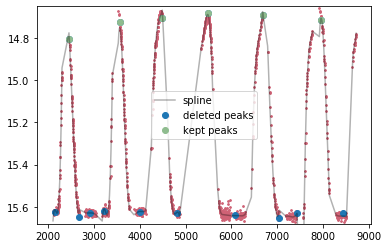

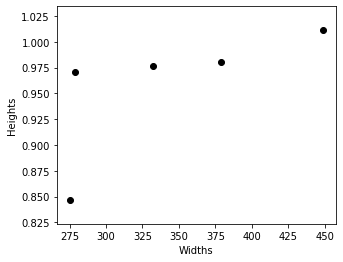

In [33]:
iband,vband = o.getIV(128,cross2,stack=True,plot=False,mlist=['OII I','OIII I','OIV I'])
trend,minloc = peaks(iband)
ws,hs = allwidths(iband,trend,minloc,plot=False) #last flare not completed
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')
print(seps)

[742.02144 557.2607  708.03314 841.78439]


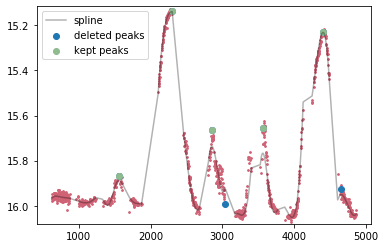

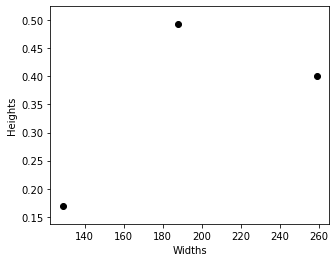

In [34]:
#needed to adjust frac on this one to get small peak -- this may be the case when amplitudes so variable

#and sampling uncelar for one
iband,vband = o.getIV(132,cross2,stack=True,plot=False,mlist=['OII I','OIII I','OIV I'])
trend,minloc = peaks(iband,frac=0.2)
ws,hs = allwidths(iband,trend,minloc,plot=False) #last flare not completed
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
plt.scatter(ws,hs,color='black')
plt.ylabel('Heights')
plt.xlabel('Widths')
print(seps)

#### a couple other sources

Text(0.5, 0, 'Widths')

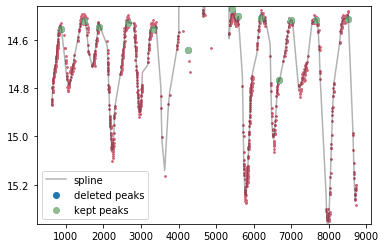

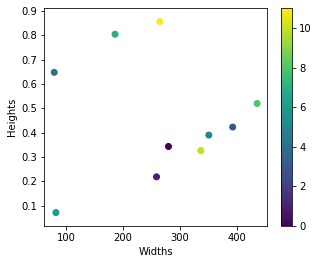

In [35]:
#try on other source
iband,vband = o.getIV(7,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
#get order of flares 
order = np.arange(len(ws))
# tims = np.array(tims)
plt.scatter(ws,hs,c=order)
plt.colorbar()
plt.ylabel('Heights')
plt.xlabel('Widths')

Text(0.5, 0, 'Widths')

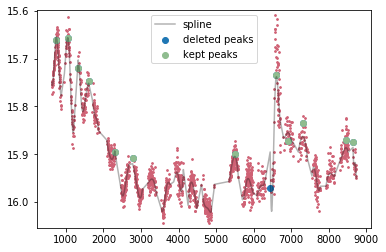

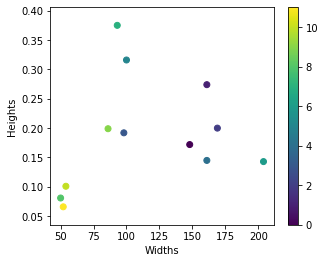

In [36]:
#try on other source
iband,vband = o.getIV(6,cross,stack=True,plot=False)
trend,minloc = peaks(iband)
#error for a flare after this
ws,hs = allwidths(iband,trend,minloc,plot=False) 
seps = np.array(iband['MJD-50000'][minloc][1:]-iband['MJD-50000'][minloc][:-1])
plt.figure(figsize=(5,4))
order = np.arange(len(ws))
plt.scatter(ws,hs,c=order)
plt.colorbar()
plt.ylabel('Heights')
plt.xlabel('Widths')

but these steps can easily fail
- maybe can play with parameters, but wouldn't run it automatically

### use to find periodogram peak widths

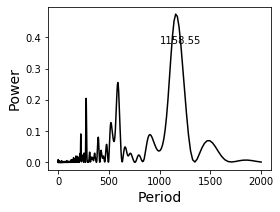

In [37]:
iband,vband = o.getIV(48,cross,stack=True,plot=False)
freq,power,bp = o.periodogram(iband,minp=2,maxp=2000,more=True,samples=10)

In [38]:
#identify peaks
reload(o)
pf = o.findpeaks(freq,power,sigma=20,distance=50,div=2,pkorder=True)

In [39]:
pf[:5]

period     power  ind
0  1158.554972  0.474681   30
1   588.797822  0.255693   99
2   396.588908  0.080662  167
3   276.936561  0.205114  257
4   224.912833  0.091137  326

In [40]:
def pdwidth(pf,freq,power,ind=0,cut=10,retinds=False,interp=True):
    '''If cut doesn't work well, can use while loop to get indices outside of half max '''
    #half max
    half = pf.loc[ind]['power']/2 #half max
    #truncate indices used to find width
    find = int(pf.loc[ind]['ind'])
    st,end = find-cut,find+cut
    idx = np.argwhere(np.diff(np.sign(power[st:end] - half))).flatten()
    period = 1/freq
    width = period[st+idx[0]]-period[st+idx[1]]
    #if returning indices, use on period to get values and width
    if retinds: return [st+idx[1],st+idx[0]]
    else: return width

In [41]:
inds = []
for p in range(5):
    inds.append(pdwidth(pf,freq,power,ind=p,retinds=True))

In [42]:
inds

[[34, 25], [104, 94], [171, 163], [261, 251], [330, 322]]

full width: 148.90298576360783
full width: 42.01865312228858
full width: 15.236637578838724
full width: 9.348844261758643
full width: 4.899229895326243


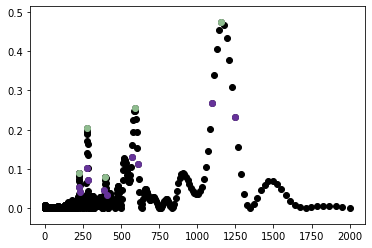

In [43]:
#plotting top five peaks
period = 1/freq
plt.scatter(period,power,color='black')
plt.scatter(pf['period'][:5],pf['power'][:5],color='darkseagreen')
for i in inds:
    plt.scatter(period[i],power[i],color='rebeccapurple')
    print(f'full width: {period[i[1]]-period[i[0]]}')

# identify all flares with faint base
- then seeing if other features can delineate between identified type and others


In [44]:
summ[np.isnan(summ['I IQR'])]

src_n     ra_deg    dec_deg  spin period  perr  est. period       sep  \
0       1  19.271511 -73.443405        0.717  0.50        3.892  0.404107   
46     51  13.516111 -72.442345      341.900  0.57        0.000  0.615308   

   name  mean I  stdev I  ...  V-I transition  Type II amp  note  I skew  \
0   NaN     NaN      NaN  ...             NaN          NaN   NaN     0.0   
46  NaN     NaN      NaN  ...             NaN          NaN   NaN     0.0   

    I kurtosis  V skew  V kurtosis  best auto det pd Part  I IQR  
0          0.0     0.0         0.0               0.0  2.0    NaN  
46         0.0     0.0         0.0               0.0  1.0    NaN  

[2 rows x 45 columns]

In [45]:
nums[30:40]

<Column name='src_n' dtype='int64' length=10>
37
38
39
40
41
44
45
46
47
48

In [46]:
nums = cross['src_n']
nums = np.array(nums)
#source that can't be read in
nums = nums[nums!=51]

In [47]:
nums

array([  2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  20,  21,  22,  23,  24,  25,  26,  27,  28,  30,  31,
        32,  34,  35,  36,  37,  38,  39,  40,  41,  44,  45,  46,  47,
        48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,
        63,  64,  65, 125, 142])

In [48]:
#part1: faint base sources in part 1
bbs1 = []
fbs1 = []
for s in nums:
    base = findbase(s,perc=95,cut=200,frac=True,checkog=True,plot=False) 
    if base == 'base at faintest': fbs1.append(s)
    if base == 'base at brightest': bbs1.append(s)


empty file for OIII I


In [49]:
nums = cross2['src_n']
nums = nums[nums!=1]
#part1: faint base sources in part 1
fbs2 = []
bbs2 = []
for s in nums:
    base = findbase(s,cross=cross2,perc=95,cut=200,frac=True,checkog=True,plot=False) 
    if base == 'base at faintest': fbs2.append(s)
    if base == 'base at brightest': bbs2.append(s)

empty file for OII I
empty file for OIII I


In [50]:
fbs2

[19, 67, 111, 119, 126, 128, 132]

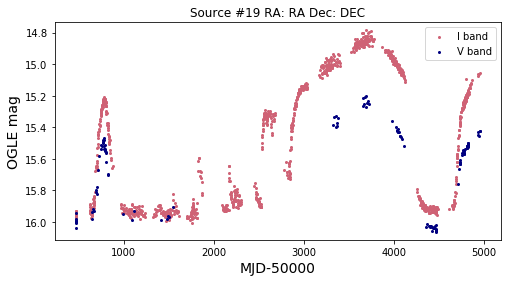

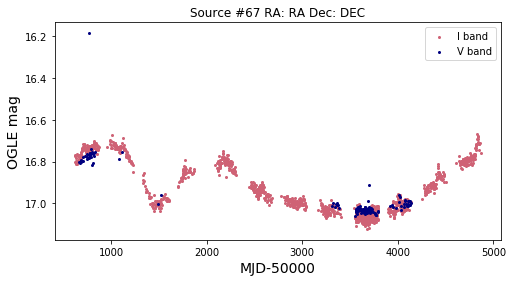

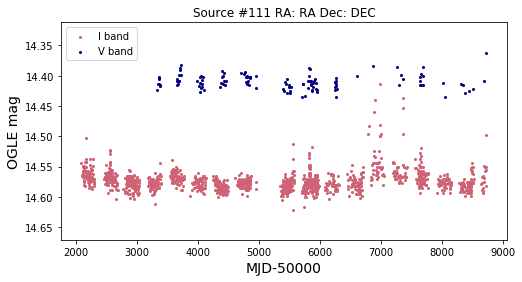

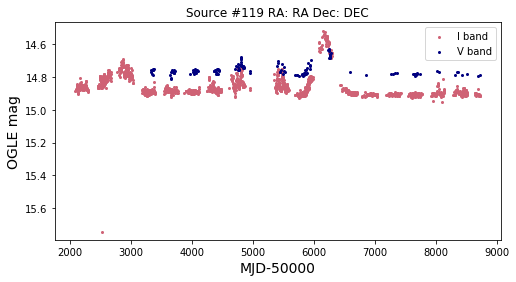

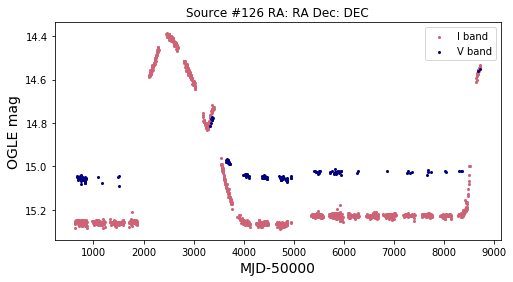

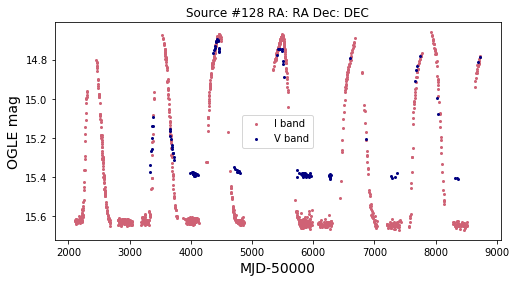

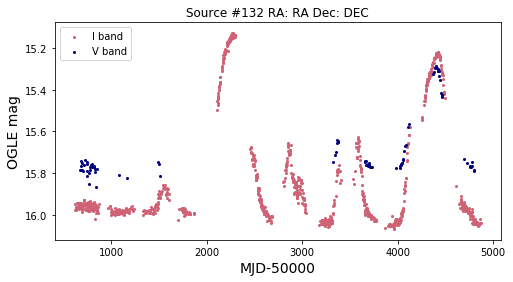

In [51]:
#plot part 2 sources with identified faint base
for f in fbs2:
    iband,vband = o.getIV(f,cross2,stack=True,both=True,plot=True,mlist=['OII I','OIII I','OIV I'])

In [52]:
#make df for each for features
fdf1 = pd.DataFrame(columns=['source','slope diff','mean width/height','max width/height','min width/height'])
fdf1['source'] = fbs1

fdf2 = pd.DataFrame(columns=['source','slope diff','mean width/height','max width/height','min width/height'])
fdf2['source'] = fbs2

for each source, calculate difference between slopes
- for the type, expect abs value of faint to be lower than bright
    - so positive is default

In [53]:
fdf1

source slope diff mean width/height max width/height min width/height
0       9        NaN               NaN              NaN              NaN
1      10        NaN               NaN              NaN              NaN
2      15        NaN               NaN              NaN              NaN
3      28        NaN               NaN              NaN              NaN
4      30        NaN               NaN              NaN              NaN
5      48        NaN               NaN              NaN              NaN
6      55        NaN               NaN              NaN              NaN
7      60        NaN               NaN              NaN              NaN
8      63        NaN               NaN              NaN              NaN

In [54]:
fdf1['power'] = np.zeros(len(fdf1))
fdf2['power'] = np.zeros(len(fdf2))

In [55]:
diffs = []
for f in fbs1:
    fslope,bslope = div_cm(f,cross=cross,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
fdf1['slope diff'] = diffs

I and V-I correlation: -0.667340526448103
V and V-I correlation: -0.39477937412506486
steeper when brighter
I and V-I correlation: -0.6832617411444406
V and V-I correlation: 0.7737722449334529
steeper when brighter
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
steeper when brighter
I and V-I correlation: -0.19384500140770167
V and V-I correlation: 0.5100391042312166
steeper when brighter
I and V-I correlation: -0.8565184040914818
V and V-I correlation: -0.4252439926010499
steeper when brighter
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
steeper when brighter
I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
steeper when brighter
I and V-I correlation: -0.7903821327759735
V and V-I correlation: -0.572353612041409
steeper when brighter
I and V-I correlation: -0.949075347309229
V and V-I correlation: -0.871228200471551
steeper when brighter


In [56]:
diffs = []
for f in fbs2:
    fslope,bslope = div_cm(f,cross=cross2,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
fdf2['slope diff'] = diffs

I and V-I correlation: -0.9634952657054523
V and V-I correlation: -0.9179149262819041
steeper when brighter
I and V-I correlation: -0.32756498369748815
V and V-I correlation: 0.10889980040748493
steeper when fainter
I and V-I correlation: -0.4499013176301471
V and V-I correlation: 0.3944493577891568
steeper when brighter
I and V-I correlation: -0.9562602917034363
V and V-I correlation: -0.8245738782996825
steeper when brighter
I and V-I correlation: -0.9659853103847417
V and V-I correlation: -0.8976564703240444
steeper when brighter
I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
steeper when brighter
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
steeper when brighter


final feature: identify peaks; get width/height ratios

In [57]:
fbs1

[9, 10, 15, 28, 30, 48, 55, 60, 63]

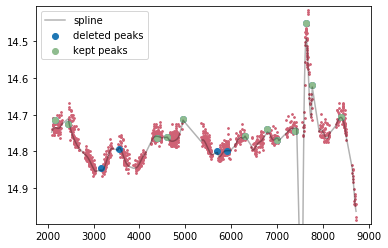

In [58]:
iband,vband = o.getIV(9,cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.35)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)

In [59]:
fdf1.columns

Index(['source', 'slope diff', 'mean width/height', 'max width/height',
       'min width/height', 'power'],
      dtype='object')

In [60]:
#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][:1] = np.max(power)

In [61]:
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][:1] = np.nanmean(ratio)
fdf1['max width/height'][:1] = np.nanmax(ratio)
fdf1['min width/height'][:1] = np.nanmin(ratio)

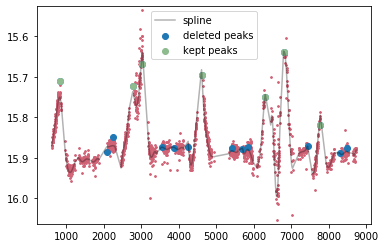

In [62]:
iband,vband = o.getIV(10,cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.4)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)

In [63]:
#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][1:2] = np.max(power)

In [64]:
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][1:2] = np.nanmean(ratio)
fdf1['max width/height'][1:2] = np.nanmax(ratio)
fdf1['min width/height'][1:2] = np.nanmin(ratio)

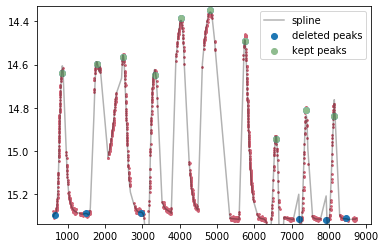

In [65]:
iband,vband = o.getIV(fbs1[2],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][2:3] = np.nanmean(ratio)
fdf1['max width/height'][2:3] = np.nanmax(ratio)
fdf1['min width/height'][2:3] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][2:3] = np.max(power)

[]


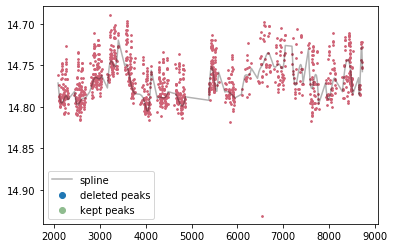

In [66]:
iband,vband = o.getIV(fbs1[3],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
fdf1['mean width/height'][3:4] = np.nanmean(ratio)
print(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][3:4] = np.max(power)

[176.]


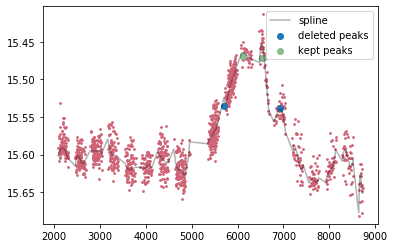

In [67]:
#want it to just identify one big peak
iband,vband = o.getIV(fbs1[4],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.75)
ws,hs = allwidths(iband,trend,[1060],frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
#not recognizing how wide the peak is
print(ws)
fdf1['mean width/height'][4:5] = np.nanmean(ratio)
fdf1['max width/height'][4:5] = np.nanmax(ratio)
fdf1['min width/height'][4:5] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][4:5] = np.max(power)

[201. 267. 264. 236. 182. 224. 258.]


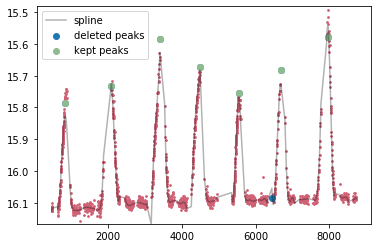

In [68]:
iband,vband = o.getIV(fbs1[5],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][5:6] = np.nanmean(ratio)
fdf1['max width/height'][5:6] = np.nanmax(ratio)
fdf1['min width/height'][5:6] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][5:6] = np.max(power)

[351. 308. 298. 277.  nan]


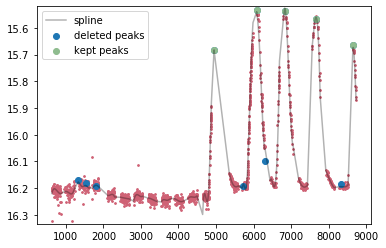

In [69]:
iband,vband = o.getIV(fbs1[6],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.3)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][6:7] = np.nanmean(ratio)
fdf1['max width/height'][6:7] = np.nanmax(ratio)
fdf1['min width/height'][6:7] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband[700:],minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][6:7] = np.max(power)

[395.  nan  nan  nan  nan 389.  nan  nan  nan  nan 383. 106.  nan]


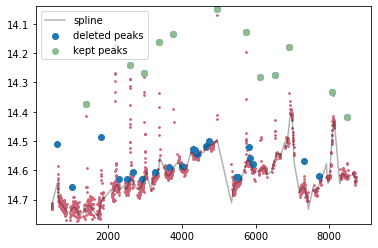

In [70]:
iband,vband = o.getIV(fbs1[7],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.4,spline=False)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][7:8] = np.nanmean(ratio)
fdf1['max width/height'][7:8] = np.nanmax(ratio)
fdf1['min width/height'][7:8] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][7:8] = np.max(power)

[ nan  nan 610.  nan  nan]


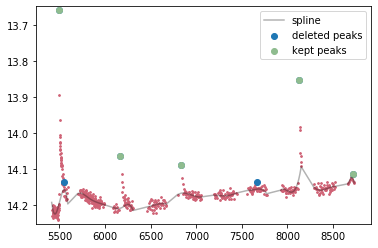

In [71]:
iband,vband = o.getIV(fbs1[8],cross,stack=True,plot=False)
trend,minloc = peaks(iband,frac=0.2,spline=False)
ws,hs = allwidths(iband,trend,minloc,frac=0.5,bounds=False,plot=False,retheight=True)
ws,hs = np.array(ws),np.array(hs)
ratio = ws/hs
print(ws)
fdf1['mean width/height'][8:9] = np.nanmean(ratio)
fdf1['max width/height'][8:9] = np.nanmax(ratio)
fdf1['min width/height'][8:9] = np.nanmin(ratio)

#get peak of periodogram
freq,power,bp = o.periodogram(iband,minp=100,maxp=1500,more=True,plot=False)
fdf1['power'][8:9] = np.max(power)

seems to get widths wrong for really sharp peaks
- turned off use of spline for sharp b/c spline doesn't model the peaks
- can write this into function

- b/c of plots below, for now not going to repeat for part 2 sources

#### analyze table

In [72]:
fdf1

source  slope diff mean width/height max width/height min width/height  \
0       9    0.388675           900.519          2212.77           217.27   
1      10    0.398631           587.287          1093.12          273.707   
2      15    0.306921           357.643              550          195.857   
3      28    0.382840               NaN              NaN              NaN   
4      30    1.226801           733.333          733.333          733.333   
5      48    1.534020           511.593          625.293          421.569   
6      55    1.328000           478.883          588.926          425.499   
7      60    1.271252           700.956          989.975          354.515   
8      63    2.273598           4586.47          4586.47          4586.47   

      power  
0  0.141398  
1  0.203506  
2  0.415984  
3  0.152858  
4  0.155127  
5  0.475541  
6  0.366636  
7  0.130178  
8  0.109079

posx and posy should be finite values
posx and posy should be finite values


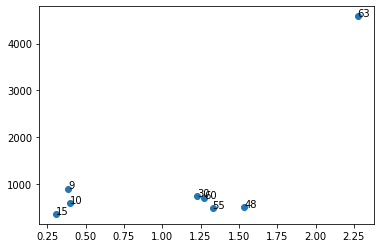

In [73]:
plt.scatter(fdf1['slope diff'],fdf1['mean width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['slope diff'],fdf1.loc[f]['mean width/height'],str(fdf1.loc[f]['source']))
#grouping of 15,55,48?

posx and posy should be finite values
posx and posy should be finite values


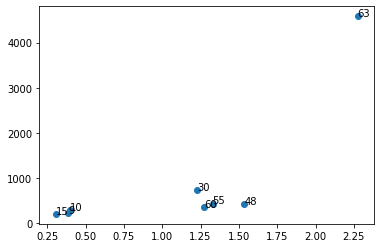

In [74]:
plt.scatter(fdf1['slope diff'],fdf1['min width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['slope diff'],fdf1.loc[f]['min width/height'],str(fdf1.loc[f]['source']))
#grouping of 15,55,48?

posx and posy should be finite values
posx and posy should be finite values


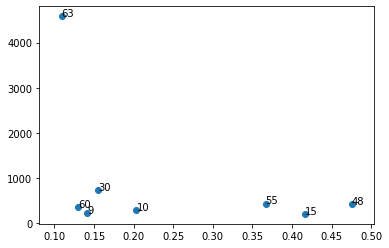

In [75]:
plt.scatter(fdf1['power'],fdf1['min width/height'])
for f in range(len(fdf1)):
    plt.text(fdf1.loc[f]['power'],fdf1.loc[f]['min width/height'],str(fdf1.loc[f]['source']))

#### compare slope diffs to population with base at brightest

In [76]:
bdf1 = pd.DataFrame(columns=['source','slope diff'])
bdf1['source'] = bbs1

bdf2 = pd.DataFrame(columns=['source','slope diff'])
bdf2['source'] = bbs2

In [77]:
diffs = []
for f in bbs1:
    fslope,bslope = div_cm(f,cross=cross,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
bdf1['slope diff'] = diffs

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
steeper when fainter
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
steeper when fainter
I and V-I correlation: -0.9670343623561133
V and V-I correlation: -0.9225217209125162
steeper when brighter
I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219
steeper when fainter
I and V-I correlation: -0.9743333607524376
V and V-I correlation: -0.9241167283255649
steeper when fainter
I and V-I correlation: -0.9273513917435414
V and V-I correlation: -0.8016300560930327
steeper when brighter
I and V-I correlation: -0.8996473434922264
V and V-I correlation: -0.4705792987062251
steeper when fainter
I and V-I correlation: 0.008207309264156904
V and V-I correlation: 0.1943980841976312
steeper when fainter
I and V-I correlation: -0.8678520855167449
V and V-I correlation: -0.7253066994414351
steeper when fainter
I and V-I correlation: -0.66873745697

In [78]:
diffs = []
for f in bbs2:
    fslope,bslope = div_cm(f,cross=cross2,interp=[],vband=[],frac=0.3,plot=False,findcorr=False)
    diffs.append(np.abs(bslope) - np.abs(fslope))
bdf2['slope diff'] = diffs

I and V-I correlation: -0.6056653161259252
V and V-I correlation: 0.08561860739395792
steeper when brighter
I and V-I correlation: -0.8816222525107474
V and V-I correlation: 0.15610819642368973
steeper when brighter
empty file for OII I
I and V-I correlation: nan
V and V-I correlation: 1.0
I and V-I correlation: -0.14960268017224718
V and V-I correlation: 0.9182068428667877
steeper when fainter
I and V-I correlation: -0.7418541628472648
V and V-I correlation: -0.4623167530237583
steeper when fainter
I and V-I correlation: -0.9149324003847996
V and V-I correlation: -0.5085433409713094
steeper when brighter
I and V-I correlation: -0.3634415884802355
V and V-I correlation: 0.5967636297255688
steeper when brighter


In [79]:
allbdiff = np.concatenate([bdf1['slope diff'],bdf2['slope diff']])

In [80]:
allfdiff = np.concatenate([fdf1['slope diff'],fdf2['slope diff']])

Text(0.5, 0, 'Bright CM Slope - Faint CM Slope')

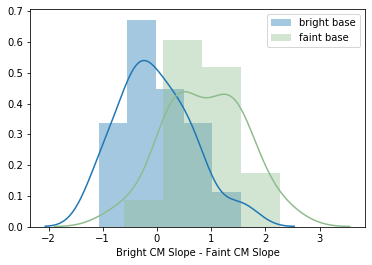

In [81]:
a = sb.distplot(allbdiff,label='bright base')

a = sb.distplot(allfdiff,color='darkseagreen',label='faint base')
plt.legend()
plt.xlabel('Bright CM Slope - Faint CM Slope')

possible difference but doesn't appear as significant, at least not enough to predict

In [82]:
scipy.stats.ttest_ind(allfdiff,allbdiff)

Ttest_indResult(statistic=3.6759441867575835, pvalue=0.0008910219479096046)

# loops/multiple V-I for single I 
- connection to certain features?

In [8]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [199]:
def histpeaks(hist,diff=2,fracdiff=0.1):
    if fracdiff>0:
        #reset diff based on max height in hist
        maxn = np.max(hist[0])
        diff = fracdiff*maxn
    pkinds = []
    pks = []
    maxn = np.max(hist[0])
    c = 0
    for i in hist[0]:
        if c == 0 and i-hist[0][1]>=diff: nbool = True
        elif c<len(hist[0])-diff and i-hist[0][c+1]>=diff and i-hist[0][c-1]>=diff: nbool = True
        elif c==len(hist[0])-1 and i-hist[0][c-1]>=diff: nbool = True
        else: nbool = False
        if nbool and i>(np.median(hist[0])):
            pkinds.append(c)
            pks.append(i)
        c+=1
    return pks,pkinds

In [210]:
def colorloop(srcn,fracdiff=0.1,diff=2):
    '''Identify if there are loop features in Iint vs. V-I plot'''
    try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4))

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    # get bright frac of Iint
    frac = 0.1
    maxi,mini = np.max(interp),np.min(interp)
    cut = maxi - frac*(maxi-mini)
    brighti = color[color['I']<cut]

    #with large range, better to plot residuals from best fit
    mod = np.polyfit(brighti['V-I'],brighti['I'],1)

    #add residuals from linear model of bright values to df
    brighti['res'] = brighti['I'] - (mod[0]*brighti['V-I'] + mod[1])


    #returns kde (x values hist[0],y values hist[1])
    plt.figure(figsize=(4,3))
    # hist = sb.distplot(brighti['res'],kde=True).get_lines()[0].get_data()
    hist = plt.hist(brighti['res'],color='darkseagreen')
    #identify histogram peaks
    pks,pkinds = histpeaks(hist,fracdiff=fracdiff,diff=diff)
    if len(pks)>=2: 
        print('loops')
        plt.text(np.median(hist[1]),np.max(hist[0])-1,'loops')
    else: 
        print('no loops')
        plt.text(np.median(hist[1]),np.max(hist[0])-1,'no loops')

    return pks,pkinds

I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
loops
[12.0, 8.0, 6.0]


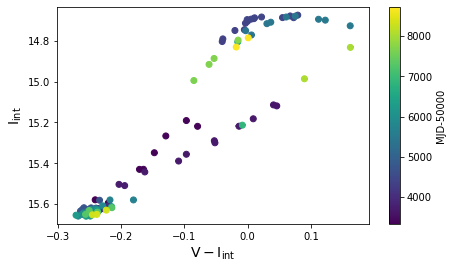

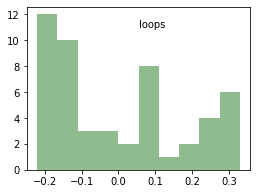

In [207]:
pk,inds = colorloop(128)
print(pk)

I and V-I correlation: -0.6254613949678095
V and V-I correlation: 0.2752110302977543
no loops
[30.0]


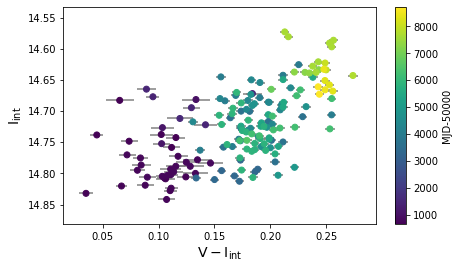

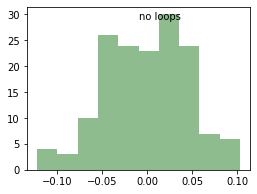

In [208]:
pk,inds = colorloop(72)
print(pk)

I and V-I correlation: -0.6677821537439047
V and V-I correlation: 0.17975703286765632
no loops
[41.0]
I and V-I correlation: -0.44719767996792303
V and V-I correlation: -0.2921974309963761
loops
[13.0, 11.0]
I and V-I correlation: -0.32756498369748815
V and V-I correlation: 0.10889980040748493
no loops
[88.0]
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
loops
[12.0, 9.0]
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
loops
[10.0, 14.0]
I and V-I correlation: -0.9664953395224388
V and V-I correlation: -0.8812431463201372
no loops
[]


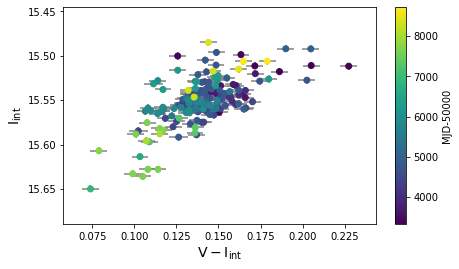

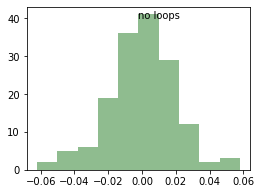

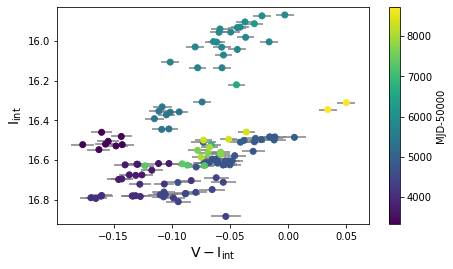

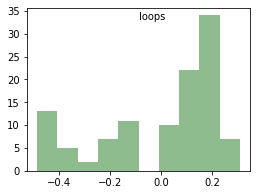

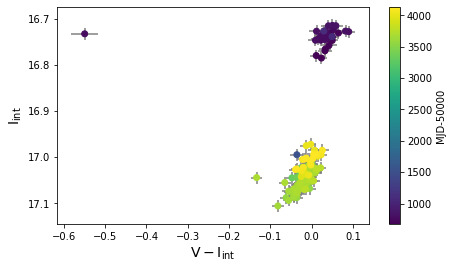

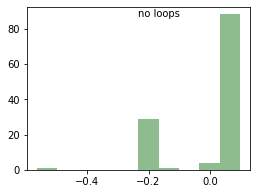

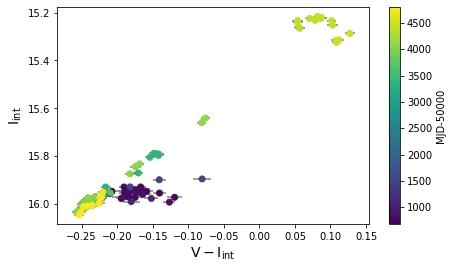

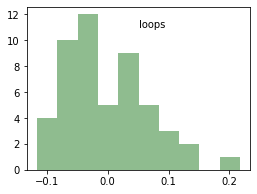

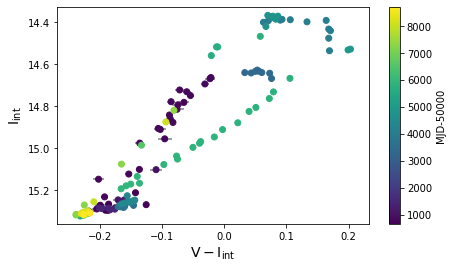

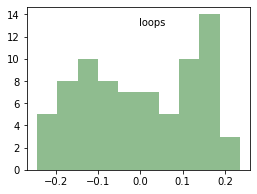

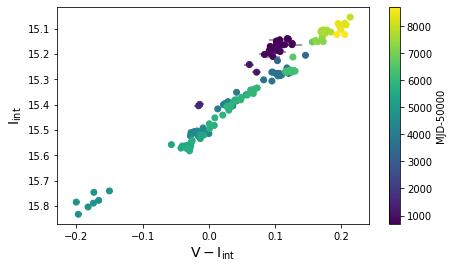

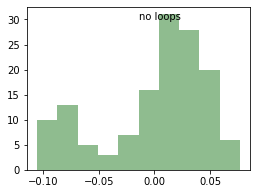

In [209]:
#results agree with by-eye
sources = [5,35,67,132,15,24]
for s in sources:
    pk,inds = colorloop(s)
    print(pk)

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642
no loops
[30.0]
I and V-I correlation: -0.8744251563223343
V and V-I correlation: -0.7590429450237982
no loops
[27.0]
I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219
loops
[49.0, 10.0, 11.0]
I and V-I correlation: -0.883934340856408
V and V-I correlation: 0.6471296353848744
loops
[31.0, 15.0]
I and V-I correlation: 0.008207309264156904
V and V-I correlation: 0.1943980841976312
loops
[43.0, 16.0, 19.0]
I and V-I correlation: -0.8150152676339503
V and V-I correlation: -0.5866867635448035
no loops
[33.0]
I and V-I correlation: -0.7418541628472648
V and V-I correlation: -0.4623167530237583
no loops
[68.0]
I and V-I correlation: -0.8678520855167449
V and V-I correlation: -0.7253066994414351
loops
[23.0, 39.0]
I and V-I correlation: -0.4230636455926597
V and V-I correlation: 0.021972129599033417
no loops
[]


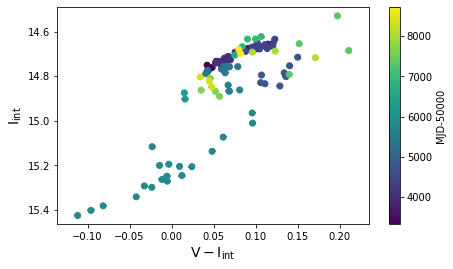

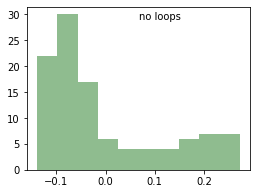

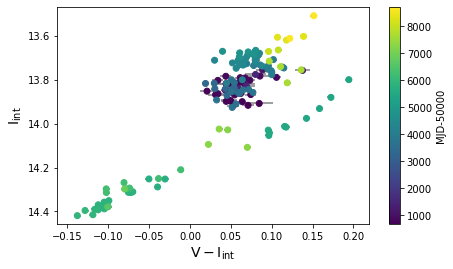

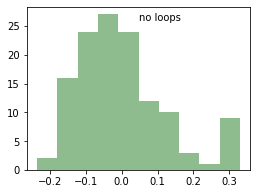

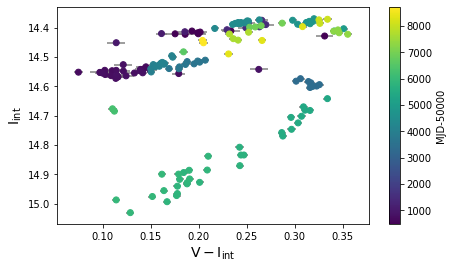

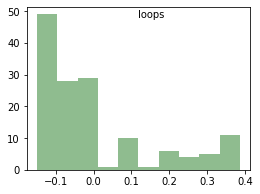

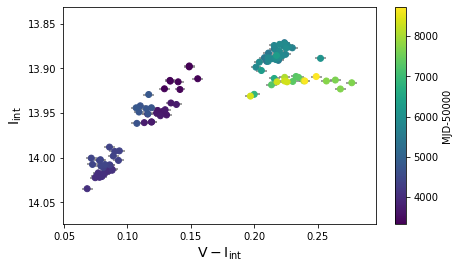

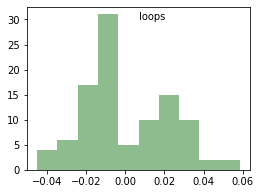

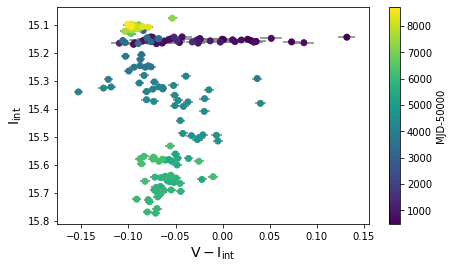

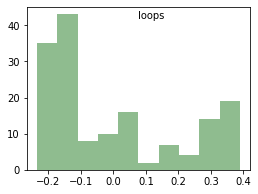

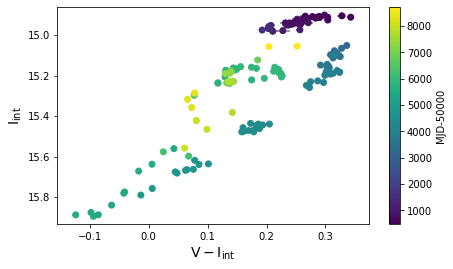

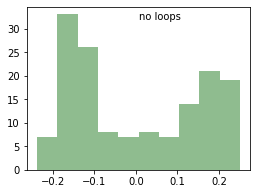

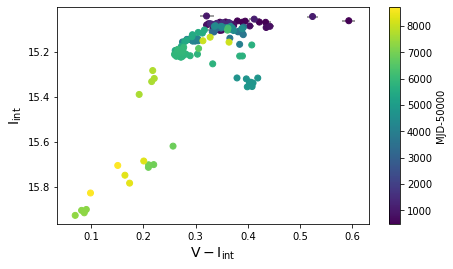

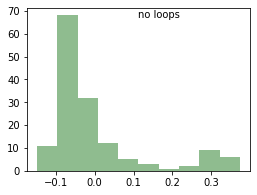

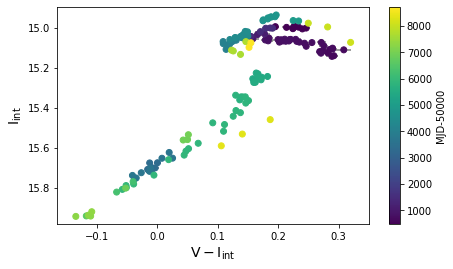

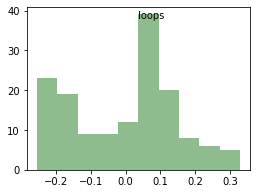

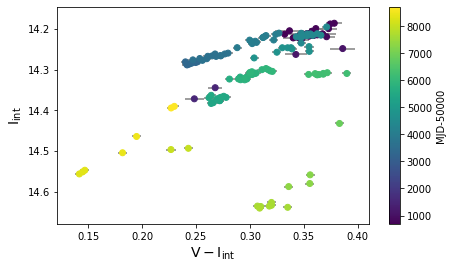

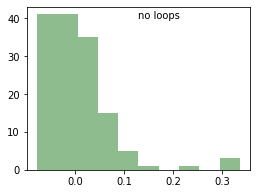

In [211]:
#trying more sources with and without loops -- more disagreements here, esp b/c of low sampling at one end biasing
sources = [3,125,16,4,41,87,80,46,116]
for s in sources:
    pk,inds = colorloop(s)
    print(pk)

#### add arrows to help by-eye and loop determination/direction

In [235]:
def colortime(srcn):
    try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)    
    #make color mag diagram
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4))

    fig, ax1 = plt.subplots(figsize=(12,4))

    im = ax1.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black',marker='x')
    ax1.set_ylabel('V-I')
    # plt.colorbar(im)
    ax2 = ax1.twinx()
    ax2.set_ylabel('I mag', color=pink); ax2.tick_params(axis='y', labelcolor=pink)
    ax2.scatter(iband['MJD-50000'],iband['I mag'],color=pink,alpha=0.3,s=4)
    # ax2.scatter(vband['MJD-50000'],vband['V mag'],color='darkseagreen',alpha=0.3,s=4)
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax2.set_ylim(maxi+.02,mini-.02)

    ax1.set_xlabel('MJD-50000')

I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
I and V-I correlation: -0.9659853103847417
V and V-I correlation: -0.8976564703240444


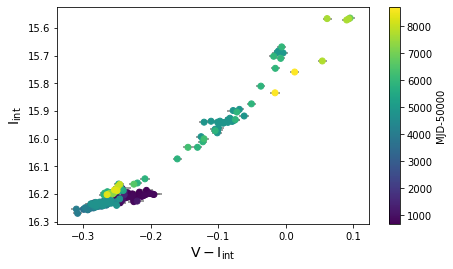

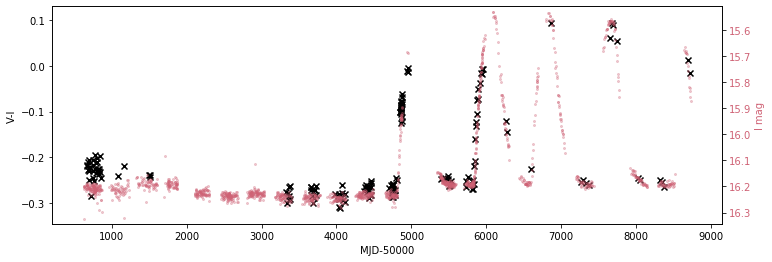

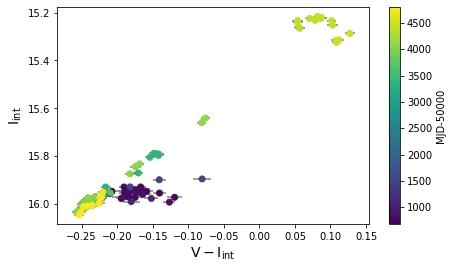

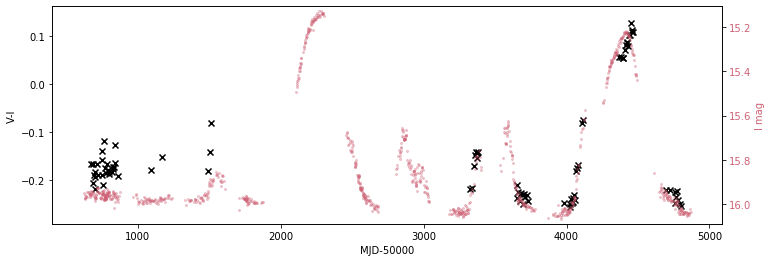

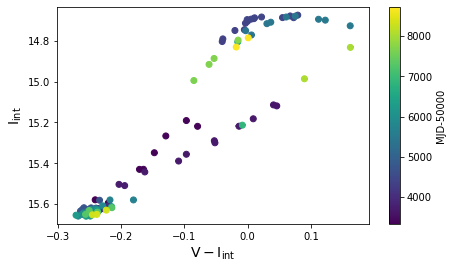

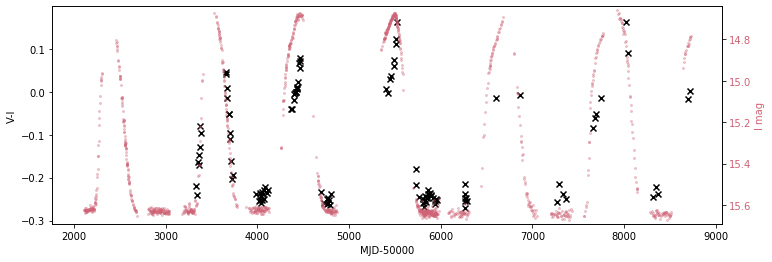

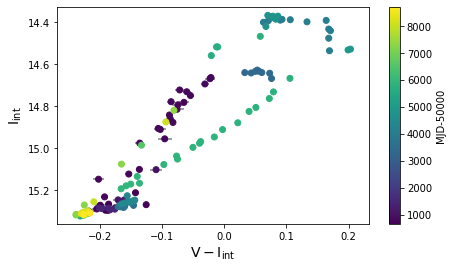

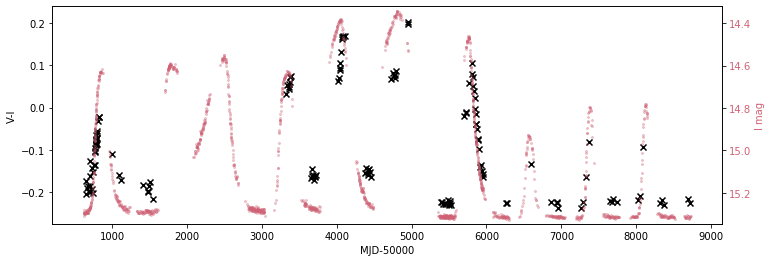

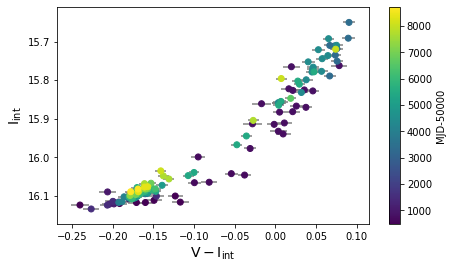

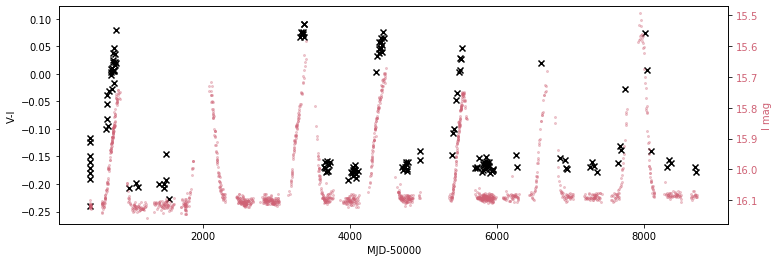

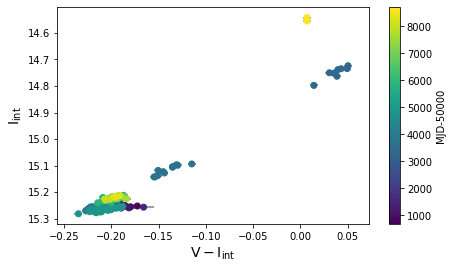

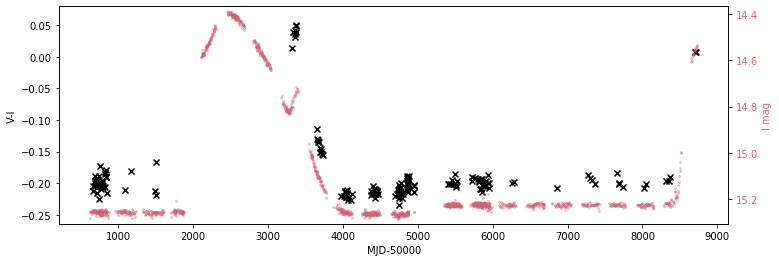

In [238]:
sources = [55,132,128,15,48,126]
for s in sources: colortime(s)

In [331]:
def carrow(vband,interp,retvect=False):
    '''Add option to first get LCs and interpolated I'''
    vi = vband['V mag']-interp
    plt.scatter(vi,interp,color=pink)
    #vectors
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    plt.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='darkseagreen',alpha=0.5)
    #flip I mag axis
    maxi,mini = np.max(interp),np.min(interp)
    plt.ylim(maxi+.02,mini-.02)
    plt.ylabel('I mag',fontsize=13)
    plt.xlabel('V-I',fontsize=13)
    if retvect: return xvect,yvect

I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701


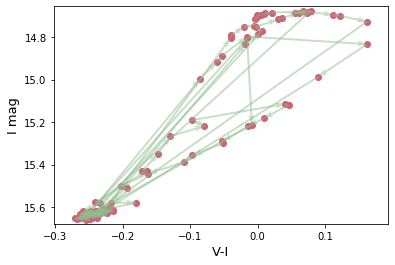

In [332]:
iband, vband = o.getIV(128,cross2,stack=True,plot=False,mlist=mlist2) 
interp = o.colormag(iband,vband,retint=True,both=False,plot=False,figsize=(7,4))
carrow(vband,interp)

I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383
I and V-I correlation: -0.9784986197610509
V and V-I correlation: -0.8992727263873777
I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079
I and V-I correlation: -0.9647345966389136
V and V-I correlation: -0.9002903341106792
I and V-I correlation: -0.9659853103847417
V and V-I correlation: -0.8976564703240444


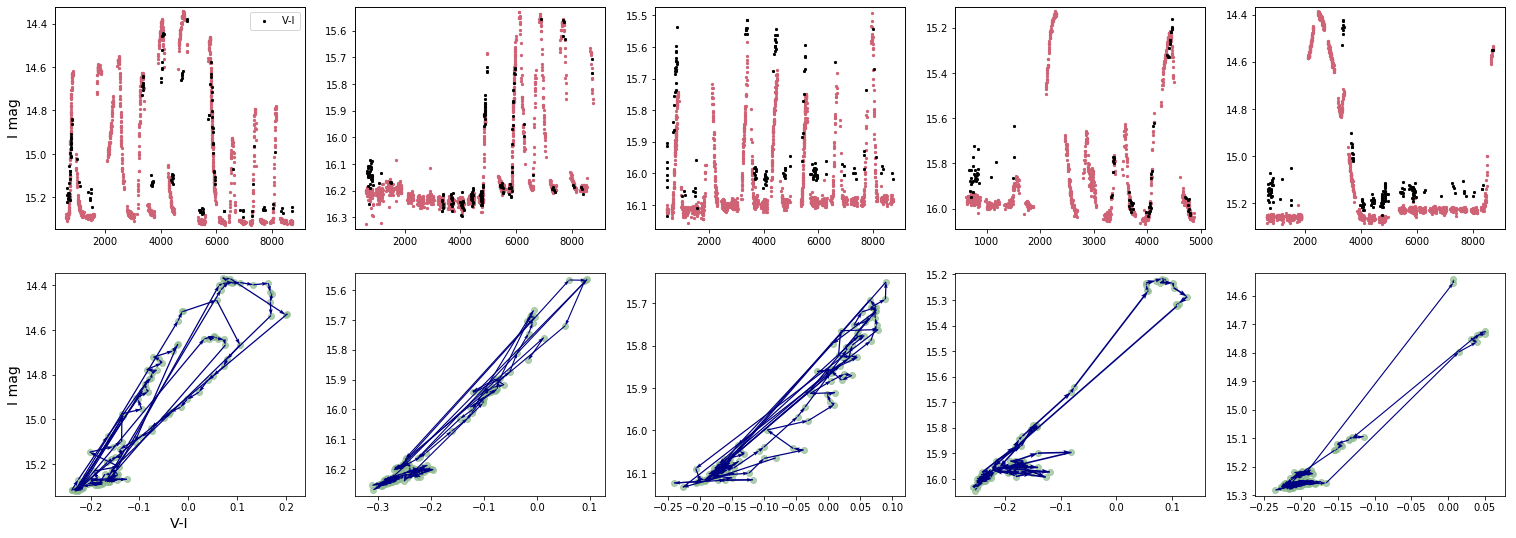

In [283]:
# for now, plot these for all of this type
fig,ax = plt.subplots(2,5,figsize=(26,9))
c = 0
for s in [15,55,48,132,126]:
    try: iband, vband = o.getIV(s,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=False,mlist=mlist2) 
    #get interpolated I
    interp = o.colormag(iband,vband,retint=True,both=False,plot=False)
    #plot color mag with arrows
    vi = vband['V mag']-interp
    ax[1][c].scatter(vi,interp,color='darkseagreen',alpha=0.7)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax[1][c].quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='navy')#,scale_units='xy', scale=1
    maxi,mini = np.max(interp),np.min(interp)
    ax[1][c].set_ylim(maxi+.02,mini-.02)
    #also plot LC
    ax[0][c].scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=5)
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax[0][c].set_ylim(maxi+.02,mini-.02)
    ax2 = ax[0][c].twinx()
    im = ax2.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black',marker='x',s=5,label='V-I')
    if c==0: ax2.legend()
    ax2.set_yticks([])
    c+=1
ax[1][0].set_ylabel('I mag',fontsize=14)
ax[0][0].set_ylabel('I mag',fontsize=14)
ax[1][0].set_xlabel('V-I',fontsize=14)
# plt.savefig('Figs/colormagarrows.png',dpi=200,bbox_inches='tight')

**because of flipping of y-axis, clockwise arrows have opposite signs**
- usually going down in I and up in V-I or down in V-I and up in I mag
- just a tthe turnover it goes up V-I and up in mag

In [333]:
def colorvec(srcn,frac=0.5,plotcm=True):
    try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
    interp = o.colormag(iband,vband,retint=True,both=False,plot=False)
    #plot color mag with arrows
    if plotcm:carrow(vband,interp)
    vi = vband['V mag']-interp
    #make df so that can be filtered to just brighter part of color-mag 
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vi
    maxi,mini = np.max(interp),np.min(interp)
    irange = maxi-mini
    cut = maxi - 0.5*irange

    bright = color[color['I']<cut]
    #to also cut out brightest
    # bright = bright[bright['I']>cut2]
    bi = np.array(bright['I'])
    bvi = np.array(bright['V-I'])

    yvect = bi[1:]-bi[:-1]
    xvect = bvi[1:]-bvi[:-1]
    if plotcm: plt.figure(figsize=(5,4))
    plt.scatter(xvect,yvect,color='black')
    #dividing quadrants
    plt.axvline(0,color='darkseagreen')
    plt.axhline(0,color='darkseagreen')
    plt.ylabel('I mag change')
    plt.xlabel('V-I mag change')

I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701


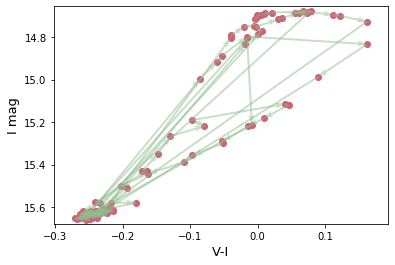

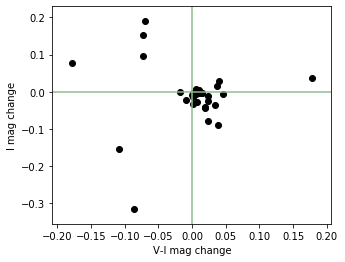

In [334]:
colorvec(128)

I and V-I correlation: -0.9708981007790428
V and V-I correlation: -0.7540319474968079


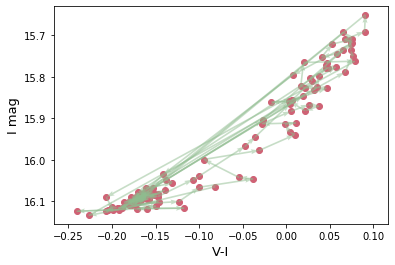

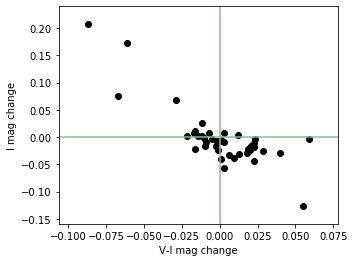

In [335]:
colorvec(48)

I and V-I correlation: -0.9670343623561133
V and V-I correlation: -0.9225217209125162


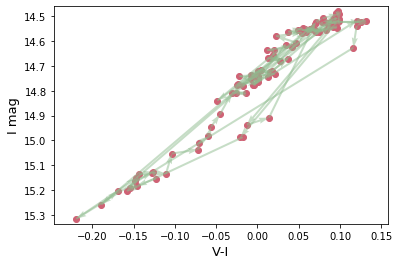

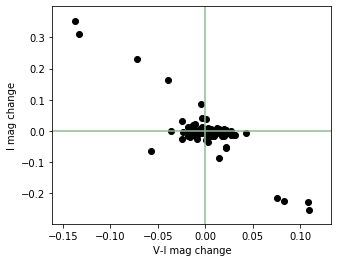

In [336]:
colorvec(7)

> **continue using these vectors for color-mag feature identification**
> - normal redder when brighter will have pretty tight neg correlation; same as redder when brighter
> - whereas loops have changes of direction so have more in the other two quadrants
> - perhaps can identify clusters etc.

# continuous amplitude change
- use peak heights from function above to check if amplitudes monotonically changing

# look for periodicity in 15,55,48,128,132
- then other sources: 73,86,97,128
- look for changing period in 72

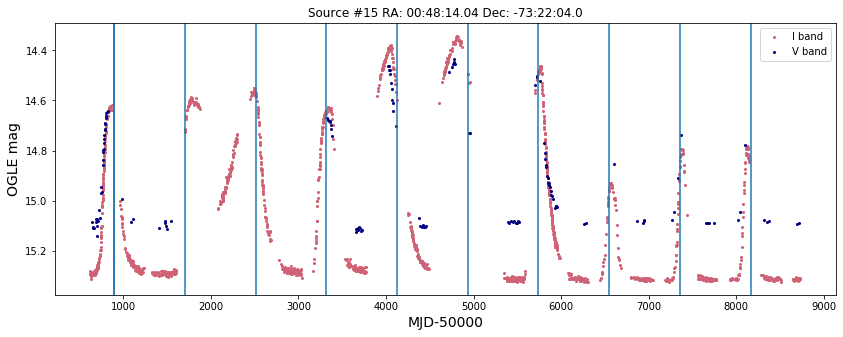

In [83]:
#15
ilist,vlist = o.getIV(15,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
plt.axvline(900)
for i in range(10):
    plt.axvline(900+807*i)

sometimes under-predicts, sometimes over-predicts 

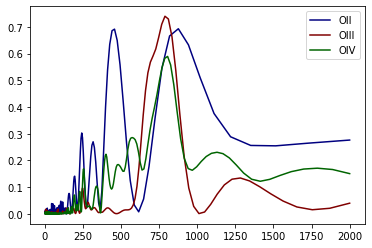

In [84]:
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

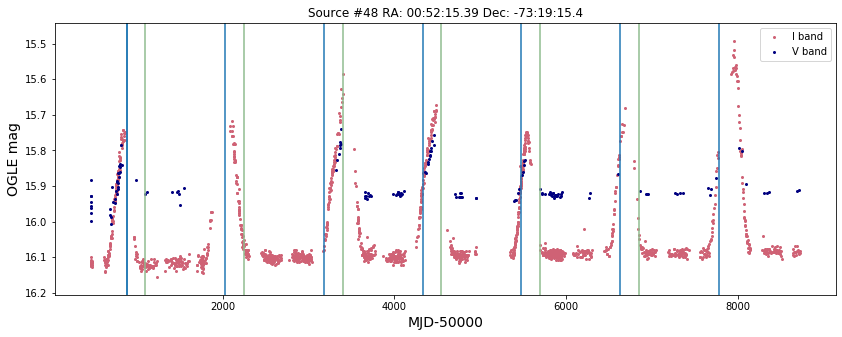

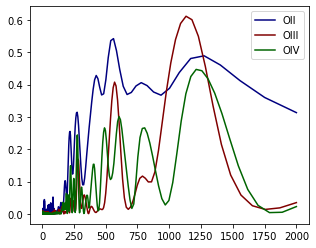

In [85]:
#48
ilist,vlist = o.getIV(48,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
plt.axvline(880)
for i in range(7):
    plt.axvline(880+1150*i)
for i in range(-2,4):
    plt.axvline(3400+1150*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

also not periodic

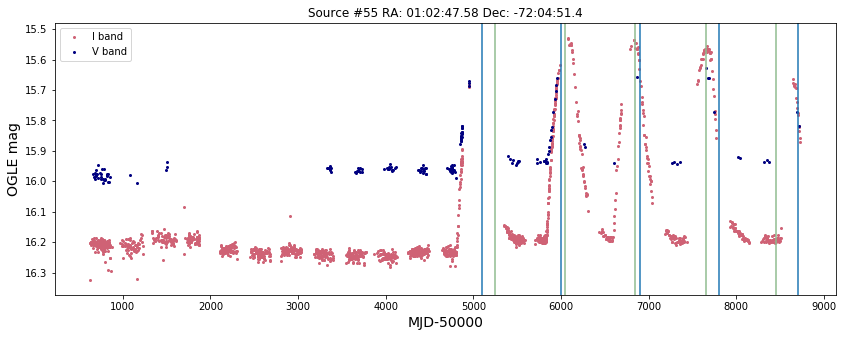

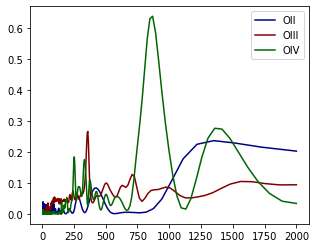

In [86]:
ilist,vlist = o.getIV(55,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
for i in range(5):
    plt.axvline(5100+900*i)
for i in range(-1,4):
    plt.axvline(6050+800*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

800 days works for a couple, but is too low on either side

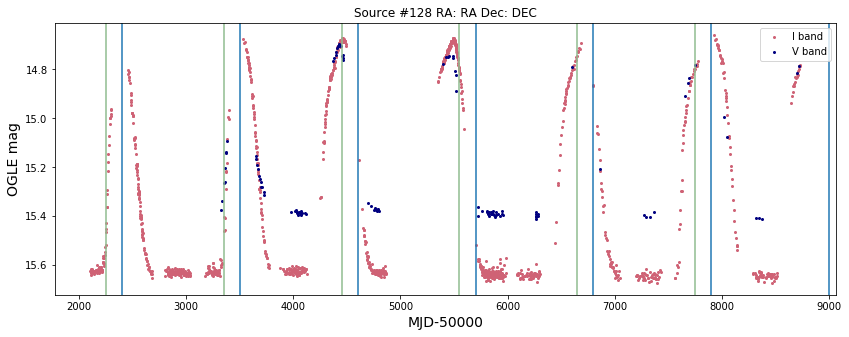

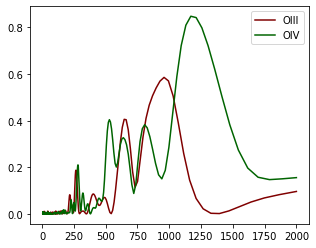

In [87]:
ilist,vlist = o.getIV(128,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
iband = vstack(ilist)
for i in range(7):
    plt.axvline(2400+1100*i)
for i in range(-2,4):
    plt.axvline(4450+1100*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='maroon',label='OIII')
plt.plot(1/f2,p2,color='darkgreen',label='OIV')
plt.legend()

longer periods at start and end

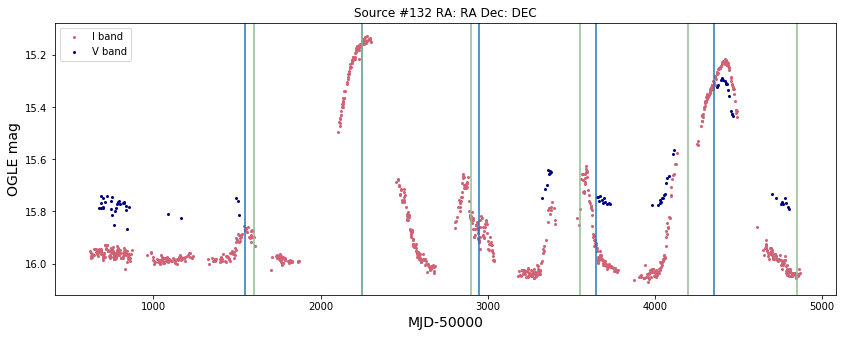

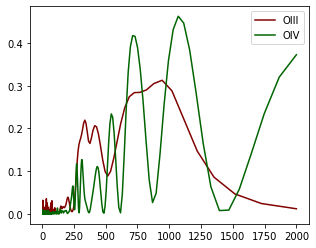

In [88]:
ilist,vlist = o.getIV(132,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# iband = vstack(ilist)
for i in range(5):
    plt.axvline(1550+700*i)
for i in range(-1,5):
    plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='maroon',label='OIII')
plt.plot(1/f2,p2,color='darkgreen',label='OIV')
plt.legend()

# follow up: 86,97,72


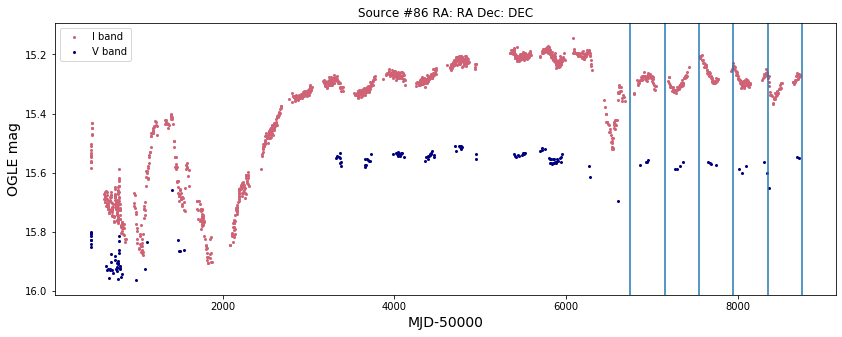

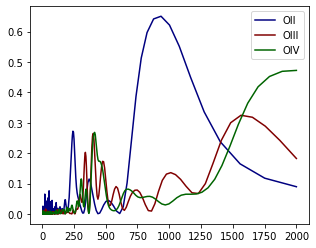

In [89]:
#mlist =['OII I','OIII I','OIV I']
ilist,vlist = o.getIV(86,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
for i in range(-2,4):
    plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

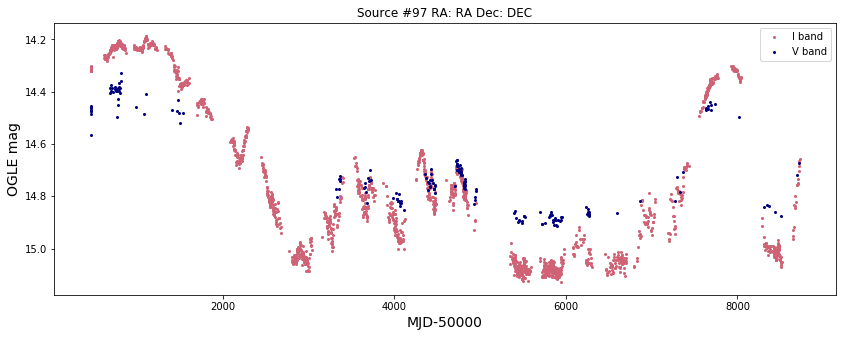

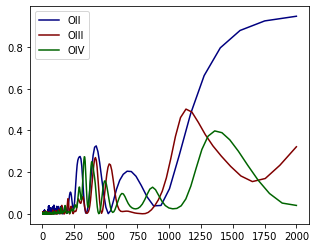

In [90]:
#mlist =['OII I','OIII I','OIV I']
ilist,vlist = o.getIV(97,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

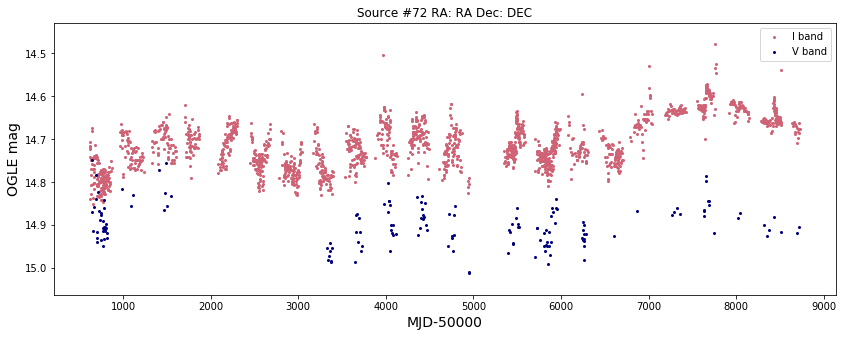

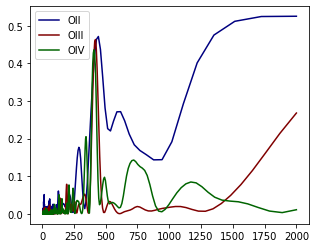

In [91]:
ilist,vlist = o.getIV(72,cross2,stack=False,plot=True,figsize=(14,5),mlist=['OII I','OIII I','OIV I'])
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')
f1,p1,bp = o.periodogram(ilist[0],maxp=2000,more=True,plot=False)
f2,p2,bp = o.periodogram(ilist[1],maxp=2000,more=True,plot=False)
f3,p3,bp = o.periodogram(ilist[2],maxp=2000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

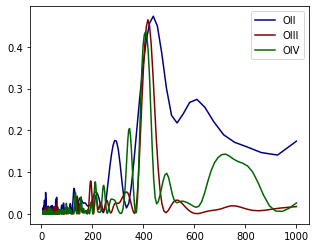

In [92]:
#decreasing period?
f1,p1,bp1 = o.periodogram(ilist[0],maxp=1000,more=True,plot=False)
f2,p2,bp2 = o.periodogram(ilist[1],maxp=1000,more=True,plot=False)
f3,p3,bp3 = o.periodogram(ilist[2],maxp=1000,more=True,plot=False)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='OII')
plt.plot(1/f2,p2,color='maroon',label='OIII')
plt.plot(1/f3,p3,color='darkgreen',label='OIV')
plt.legend()

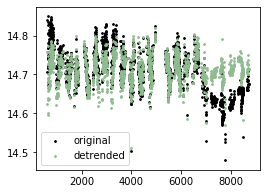

In [93]:
#phase fold each
iband = vstack(ilist)
o.detrend(iband,window=201,plot=True)
o.detrend(ilist[0],window=201,plot=False)
o.detrend(ilist[1],window=201,plot=False)
o.detrend(ilist[2],window=201,plot=False)

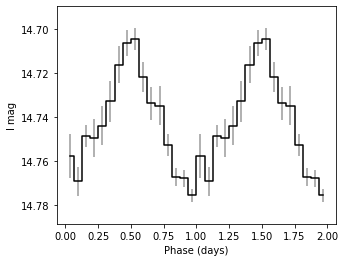

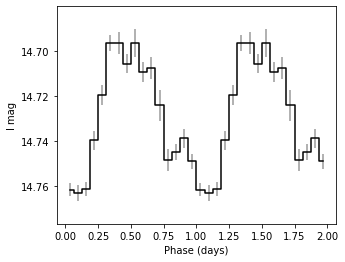

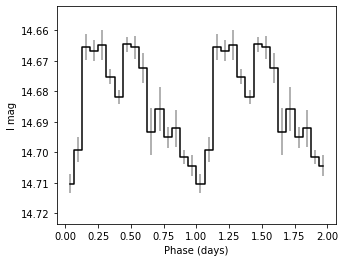

In [94]:
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bp2,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bp3,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=-130,sterr=True,divide=True,label='')


first two look good on all three but phase-shift!

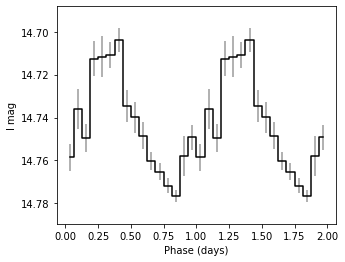

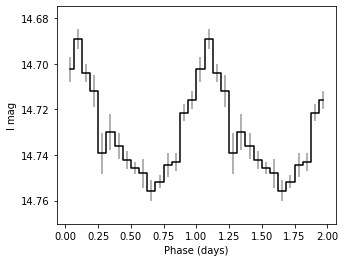

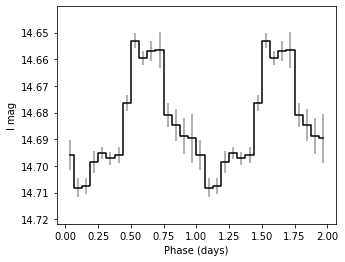

In [95]:
#use first on each 
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bp1,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')

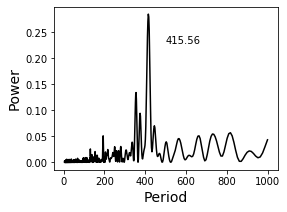

In [96]:
bpall = o.periodogram(iband,maxp=1000)

In [97]:
bp1

<Quantity 438.58573177>

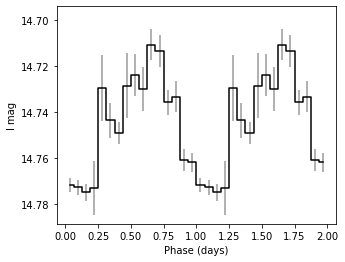

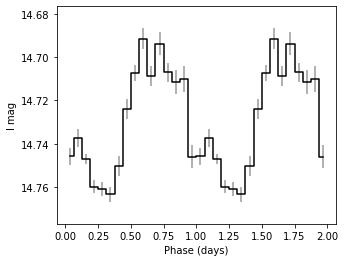

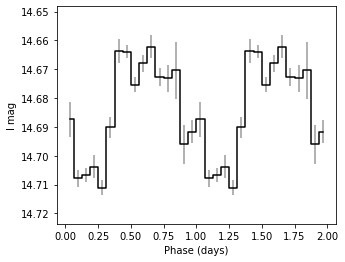

In [98]:
#use overall best on all three
plt.figure(figsize=(5,4))
o.phasestep(ilist[0],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[1],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.figure(figsize=(5,4))
o.phasestep(ilist[2],bpall,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')

no phase shift so not great evidence of change

In [99]:
bpall

<Quantity 415.56257149>

In [100]:
row = summ[summ['src_n']==72]
row['best period'] = bpall
summ[summ['src_n']==72] = row

In [101]:
summ[summ['src_n']==72]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
65     72  12.142035 -73.04181          0.0  0.69    414.91345  0.588423  NaN   

       mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
65  14.713841  0.055775  ...             NaN          NaN   NaN -0.296249   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
65   -0.179276 -0.390153    0.398842        416.534718  2.0  0.081  

[1 rows x 45 columns]

# look for difference in orbital during big dips
- relationship between orbital and super-orbital
- probably move to another notebook

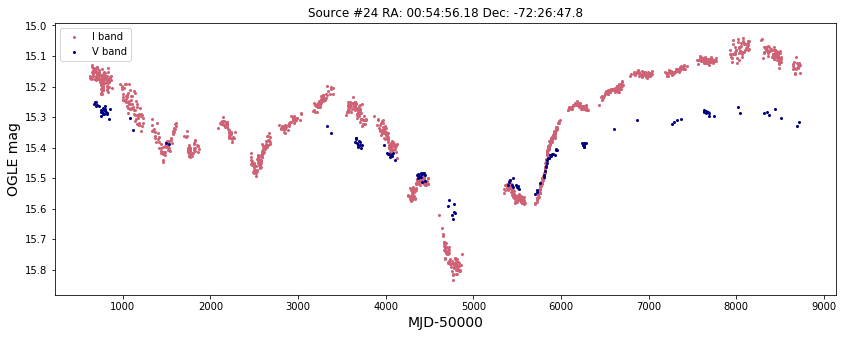

In [102]:
ilist,vlist = o.getIV(24,cross,stack=False,plot=True,figsize=(14,5))
# for i in range(-2,4):
#     plt.axvline(7550+400*i)
# for i in range(-1,5):
#     plt.axvline(2250+650*i,color='darkseagreen')


In [103]:
#best period
summ[summ['src_n']==24]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
22     24  13.734498 -72.44646        59.07  0.59         62.1  1.090329  NaN   

       mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
22  15.332253  0.177328  ...             NaN          NaN   NaN  0.549316   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
22   -0.272309  0.336276   -0.858391         60.913413  1.0  0.275  

[1 rows x 45 columns]

In [104]:
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

<Quantity 15.33349287>

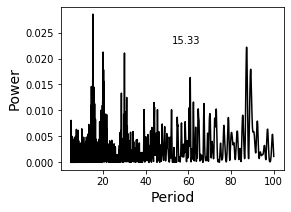

In [105]:
o.periodogram(iband,maxp=100,det=True)

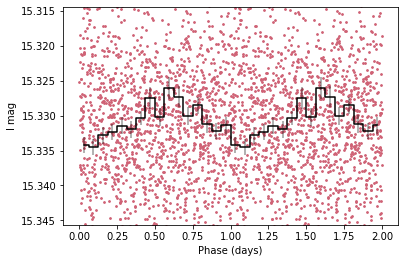

In [106]:
o.phasestep(iband,15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000']%15.33)/15.33,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%15.33)/15.33,iband['I detrend'],s=3,color=pink)

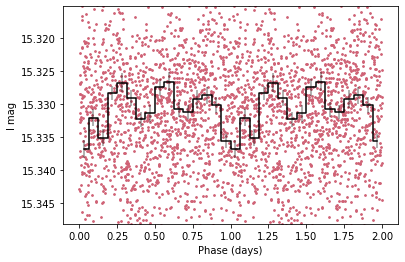

In [107]:
o.phasestep(iband,60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000']%60.9)/60.91,iband['I detrend'],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000']%60.9)/60.91,iband['I detrend'],s=3,color=pink)

(15.9, 15.1)

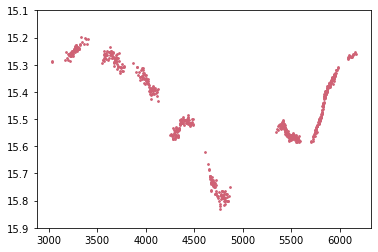

In [108]:
#find indices of dip
plt.scatter(iband['MJD-50000'][500:1200],iband['I mag'][500:1200],color=pink,s=3)
plt.ylim(15.9,15.1)

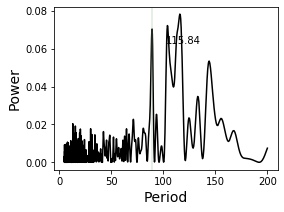

In [109]:
o.periodogram(iband[500:1200],det=True,maxp=200)
plt.axvline(89.2,color='darkseagreen',alpha=0.3)

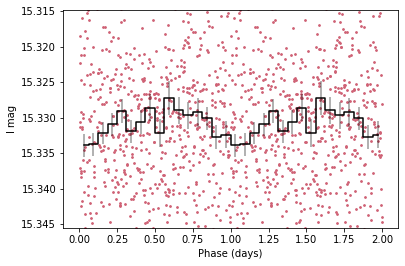

In [110]:
#15.33 during dip
o.phasestep(iband[500:1200],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][500:1200]%15.33)/15.33,iband['I detrend'][500:1200],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][500:1200]%15.33)/15.33,iband['I detrend'][500:1200],s=3,color=pink)

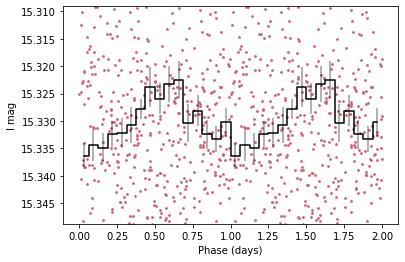

In [111]:
#before dip
o.phasestep(iband[:500],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][:500]%15.33)/15.33,iband['I detrend'][:500],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][:500]%15.33)/15.33,iband['I detrend'][:500],s=3,color=pink)

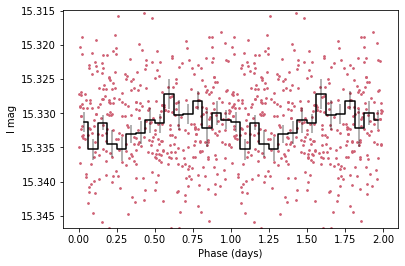

In [112]:
#after dip -- peaks a bit after 0.5 now?
o.phasestep(iband[1200:],15.33,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=70,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][1200:]%15.33)/15.33,iband['I detrend'][1200:],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][1200:]%15.33)/15.33,iband['I detrend'][1200:],s=3,color=pink)

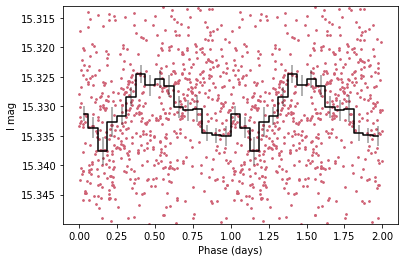

In [113]:
#just dip
pd = 89.2
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=-25,sterr=True,divide=True,label='')
plt.scatter((iband[500:1200]['MJD-50000']%pd)/pd,iband[500:1200]['I detrend'],s=3,color=pink)
plt.scatter(1+(iband[500:1200]['MJD-50000']%pd)/pd,iband[500:1200]['I detrend'],s=3,color=pink)

89.2 not effective before or after dip

found 115.84 period looks good before and during big dip, but not at all after
- and phase shift between those two

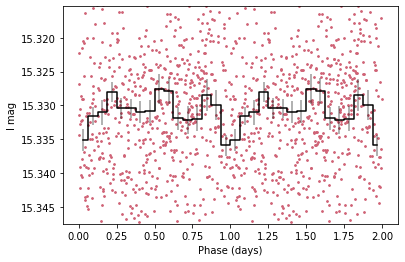

In [114]:
# during dip
o.phasestep(iband[500:1200],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][500:1200]%60.9)/60.91,iband['I detrend'][500:1200],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][500:1200]%60.9)/60.91,iband['I detrend'][500:1200],s=3,color=pink)

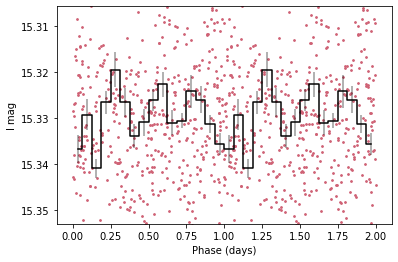

In [115]:
#before
o.phasestep(iband[:500],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][:500]%60.9)/60.91,iband['I detrend'][:500],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][:500]%60.9)/60.91,iband['I detrend'][:500],s=3,color=pink)

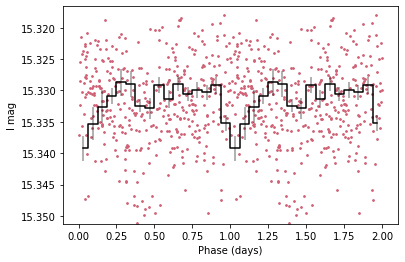

In [116]:
#after
#before
o.phasestep(iband[1200:],60.91,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='')
plt.scatter((iband['MJD-50000'][1200:]%60.9)/60.91,iband['I detrend'][1200:],s=3,color=pink)
plt.scatter(1+(iband['MJD-50000'][1200:]%60.9)/60.91,iband['I detrend'][1200:],s=3,color=pink)

60.91 not a super strong signal, but phase-fold looks good before, during, and after big dip with no apparent phase change
- plot all on same 


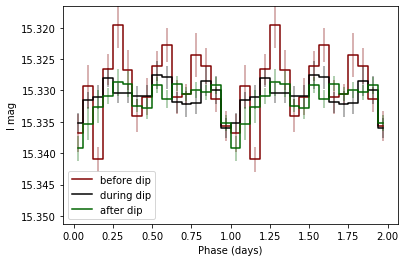

In [117]:
pd = 60.91
o.phasestep(iband[:500],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=40,sterr=True,divide=True,label='before dip')
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1200:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=40,sterr=True,divide=True,label='after dip')
plt.legend()

- no difference during dip
- confirmed 60.91 better than est. period of 62

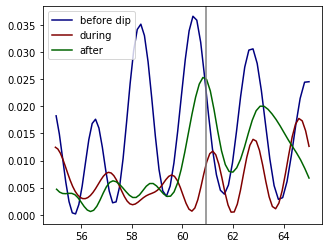

In [118]:
#zoomed in periodogram in each region
f1,p1,bp1 = o.periodogram(iband[:500],minp=55,maxp=65,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[500:1200],minp=55,maxp=65,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1200:],minp=55,maxp=65,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.legend()
plt.axvline(60.91,color='grey')

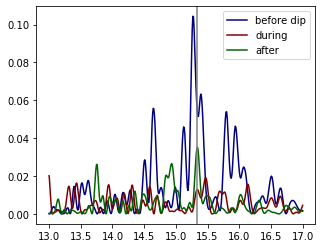

In [119]:
#zoomed in periodogram in each region
f1,p1,bp1 = o.periodogram(iband[:500],minp=13,maxp=17,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[500:1200],minp=13,maxp=17,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1200:],minp=13,maxp=17,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.legend()
plt.axvline(15.33,color='grey')

In [120]:
bp1

<Quantity 15.2679119>

15.33 more consistent? and narrower peak
- 15.27 doesn't work for others

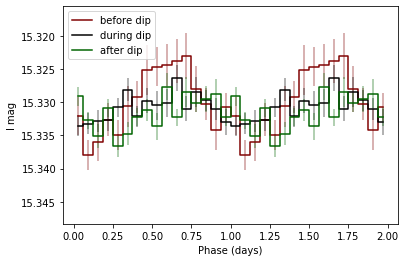

In [121]:
pd = 15.33
o.phasestep(iband[:500],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=40,sterr=True,divide=True,label='before dip')
o.phasestep(iband[500:1200],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=40,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1200:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=40,sterr=True,divide=True,label='after dip')
plt.legend()

## next big dip source: 23


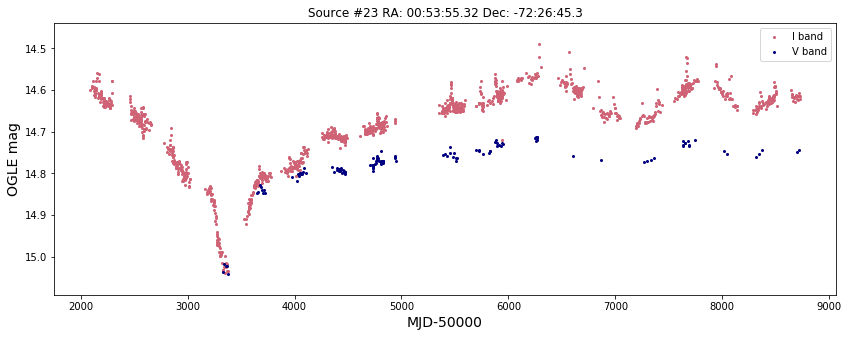

In [122]:
ilist,vlist = o.getIV(23,cross,stack=False,plot=True,figsize=(14,5))

amplitude increases with brightness? can't see the orbital peaks in dip
- investigate below

In [123]:
summ[summ['src_n']==23]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
21     23  13.480083 -72.44603        46.63   0.6       137.36  0.647529  NaN   

      mean I   stdev I  ...  V-I transition  Type II amp  note   I skew  \
21  14.68619  0.093824  ...             NaN          NaN   NaN  1.22555   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
21      1.4785  2.927194    10.50737        137.916601  1.0  0.104  

[1 rows x 45 columns]

In [124]:
iband = vstack(ilist)

(15.1, 14.4)

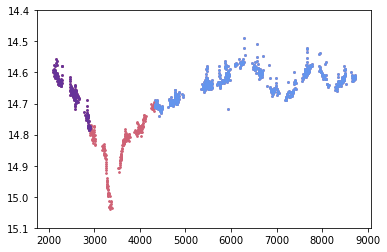

In [125]:
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
plt.scatter(iband['MJD-50000'][:200],iband['I mag'][:200],color=purple,s=3)
plt.scatter(iband['MJD-50000'][500:],iband['I mag'][500:],color=blue,s=3)

plt.ylim(15.1,14.4)

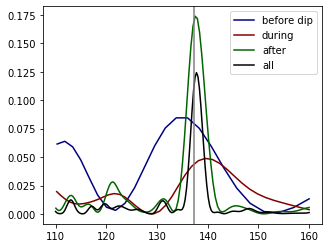

In [126]:
o.splinedetrend(iband,window=300)
#periodograms before, during, after dip
f1,p1,bp1 = o.periodogram(iband[:200],minp=110,maxp=160,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[200:500],minp=110,maxp=160,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[500:],minp=110,maxp=160,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=110,maxp=160,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(137.36,color='grey')

In [127]:
bp4

<Quantity 137.76176613>

difference could just be from number of points so now look at phase-fold

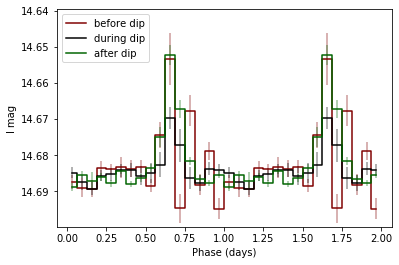

In [128]:
pd = bp4
o.phasestep(iband[:200],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[200:500],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[500:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

**much lower amplitude during dip**
- could do more by digging into the flares during the dip


# 37

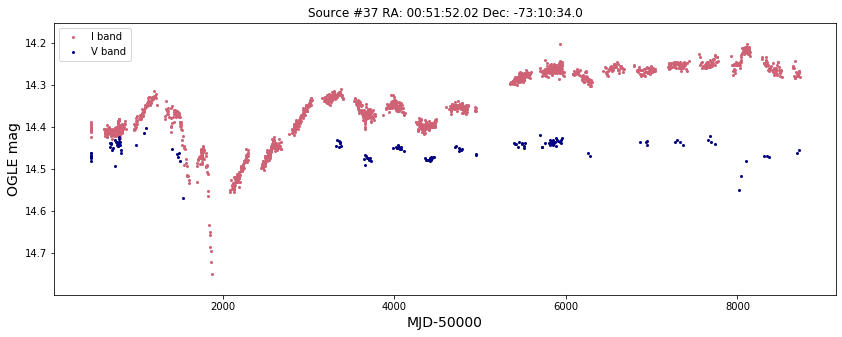

In [131]:
ilist,vlist = o.getIV(37,cross,stack=False,plot=True,figsize=(14,5))

In [134]:
summ[summ['src_n']==37]

src_n    ra_deg    dec_deg  spin period  perr  est. period       sep name  \
33     37  12.96625 -73.175835        172.0  0.87        67.88  0.927393  NaN   

       mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
33  14.347119  0.080958  ...             NaN          NaN   NaN  0.643526   

    I kurtosis    V skew  V kurtosis  best auto det pd Part    I IQR  
33    0.341968  1.780884    6.568828         68.592332  1.0  0.13075  

[1 rows x 45 columns]

In [138]:
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

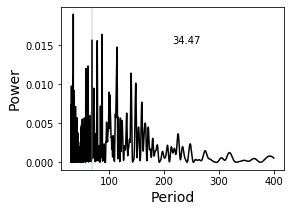

In [140]:
o.periodogram(iband,minp=30,maxp=400,det=True)
plt.axvline(68,color='darkseagreen',alpha=0.4)

(14.8, 14.15)

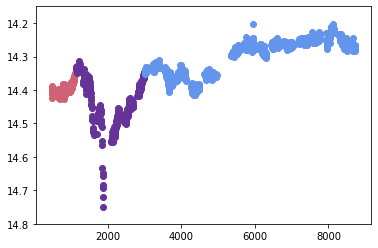

In [146]:
plt.scatter(iband['MJD-50000'][:200],iband['I mag'][:200],color=pink)
plt.scatter(iband['MJD-50000'][200:620],iband['I mag'][200:620],color=purple)
plt.scatter(iband['MJD-50000'][620:],iband['I mag'][620:],color=blue)
plt.ylim(14.8,14.15)

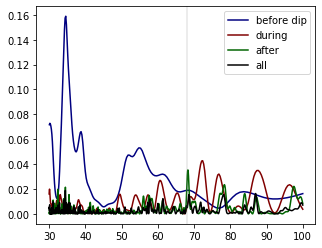

In [149]:
#periodograms before, during, after dip
f1,p1,bp1 = o.periodogram(iband[:200],minp=30,maxp=100,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[200:620],minp=30,maxp=100,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[620:],minp=30,maxp=100,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=30,maxp=100,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(68,color='grey',alpha=0.2)

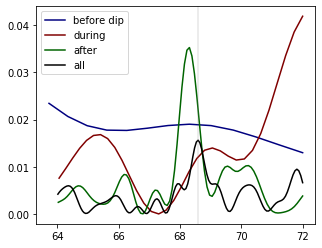

In [152]:
#periodograms before, during, after dip: zoom more
f1,p1,bp1 = o.periodogram(iband[:200],minp=64,maxp=72,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[200:620],minp=64,maxp=72,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[620:],minp=64,maxp=72,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=64,maxp=72,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(68.592332,color='grey',alpha=0.2) #best period for all; same as in auto analysis

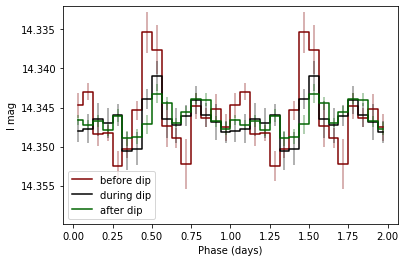

In [162]:
pd = bp4
o.phasestep(iband[:200],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[200:620],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[620:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

best phase-fold before dip; similar during and after for this period
- below: best period after results in phase shifts

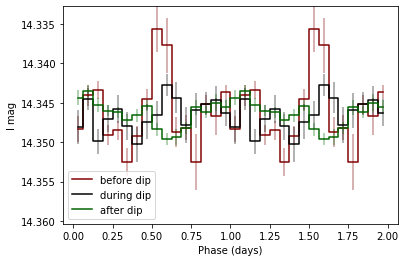

In [161]:
pd = bp3
o.phasestep(iband[:200],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[200:620],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[620:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

# 3

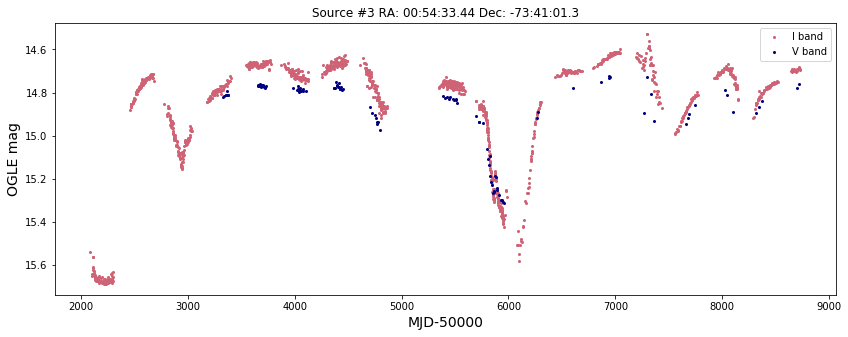

In [163]:
ilist,vlist = o.getIV(3,cross,stack=False,plot=True,figsize=(14,5))

In [178]:
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

(15.7, 14.5)

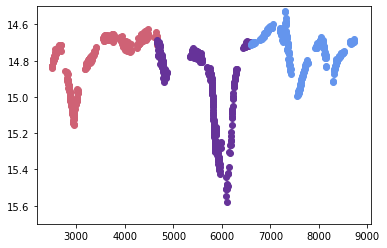

In [173]:
plt.scatter(iband['MJD-50000'][90:620],iband['I mag'][90:620],color=pink)
plt.scatter(iband['MJD-50000'][620:1100],iband['I mag'][620:1100],color=purple)
plt.scatter(iband['MJD-50000'][1100:],iband['I mag'][1100:],color=blue)
plt.ylim(15.7,14.5)

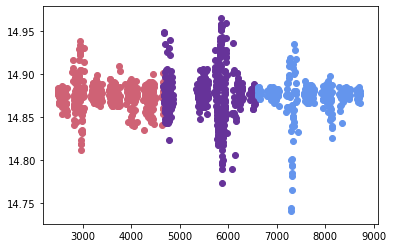

In [179]:
plt.scatter(iband['MJD-50000'][90:620],iband['I detrend'][90:620],color=pink)
plt.scatter(iband['MJD-50000'][620:1100],iband['I detrend'][620:1100],color=purple)
plt.scatter(iband['MJD-50000'][1100:],iband['I detrend'][1100:],color=blue)


In [197]:
summ[summ['src_n']==3]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
2      3  13.639167 -73.68364         2.37   0.8        18.38  0.259701  NaN   

      mean I   stdev I  ...  V-I transition  Type II amp                note  \
2  14.877813  0.267369  ...             yes          NaN  ~1 day error on pd   

     I skew  I kurtosis    V skew  V kurtosis  best auto det pd Part   I IQR  
2  1.698965    2.086592  1.458121    0.808846         17.404354  1.0  0.2325  

[1 rows x 45 columns]

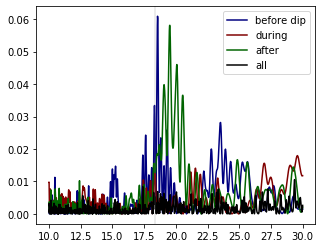

In [184]:
#periodograms before, during, after dip
f1,p1,bp1 = o.periodogram(iband[90:620],minp=10,maxp=30,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[620:1100],minp=10,maxp=30,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1100:],minp=10,maxp=30,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=10,maxp=30,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(18.38,color='grey',alpha=0.2)

In [193]:
bp4/2

<Quantity 14.68164186>

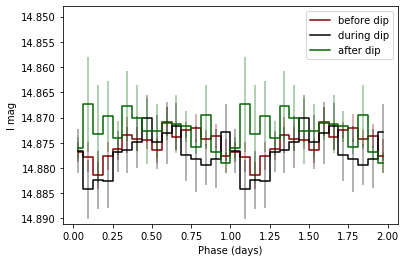

In [202]:
pd = 17.404354
o.phasestep(iband[90:620],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[620:1100],pd,16,det=True,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1100:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

come back to 3 -- thought orbital period was resolved 
- check back on notebooks

# 16

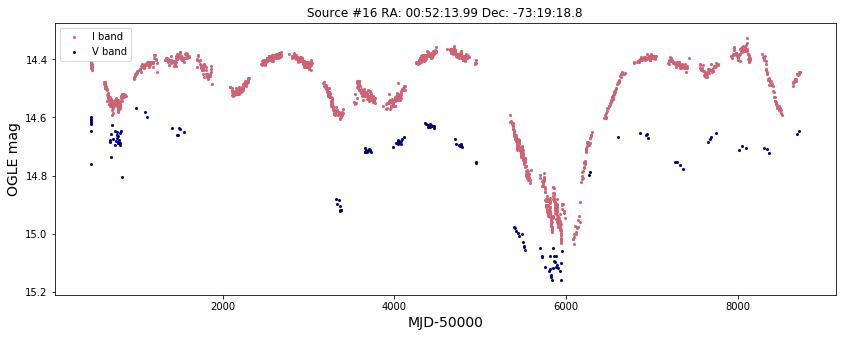

In [204]:
ilist,vlist = o.getIV(16,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

(15.2, 14.3)

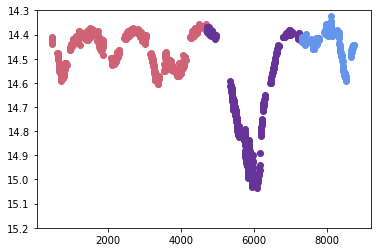

In [211]:
plt.scatter(iband['MJD-50000'][:1000],iband['I mag'][:1000],color=pink)
plt.scatter(iband['MJD-50000'][1000:1550],iband['I mag'][1000:1550],color=purple)
plt.scatter(iband['MJD-50000'][1550:],iband['I mag'][1550:],color=blue)
plt.ylim(15.2,14.3)

(14.7, 14.3)

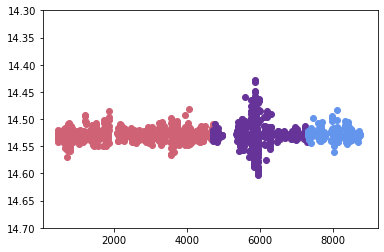

In [230]:
plt.scatter(iband['MJD-50000'][:1000],iband['I detrend'][:1000],color=pink)
plt.scatter(iband['MJD-50000'][1000:1550],iband['I detrend'][1000:1550],color=purple)
plt.scatter(iband['MJD-50000'][1550:],iband['I detrend'][1550:],color=blue)
plt.ylim(14.7,14.3)

In [213]:
summ[summ['src_n']==16]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
15     16  13.058333 -73.32166         15.3   1.0        74.51  0.357692  NaN   

       mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
15  14.529405  0.170323  ...             NaN          NaN   NaN  1.374265   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
15    0.875169  1.041327   -0.489576         74.295173  1.0   0.16  

[1 rows x 45 columns]

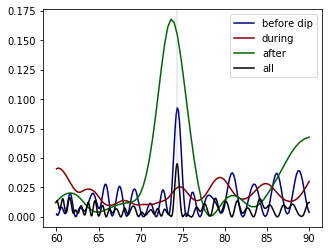

In [220]:
f1,p1,bp1 = o.periodogram(iband[:1000],minp=60,maxp=90,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[1000:1550],minp=60,maxp=90,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1550:],minp=60,maxp=90,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=60,maxp=90,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(74.3,color='grey',alpha=0.2)

In [233]:
bp4

<Quantity 74.29727641>

to do: fix colors in each example to be same in periodogram and phase-fold

In [235]:
bp2 #best period during dip

<Quantity 60.29128758>

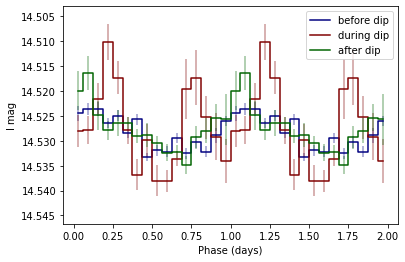

In [234]:
pd = bp1 #and bp4 look best
o.phasestep(iband[:1000],pd,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1000:1550],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1550:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

**amplitude could be higher during dip just b/c of detrending (see above)**

# 125

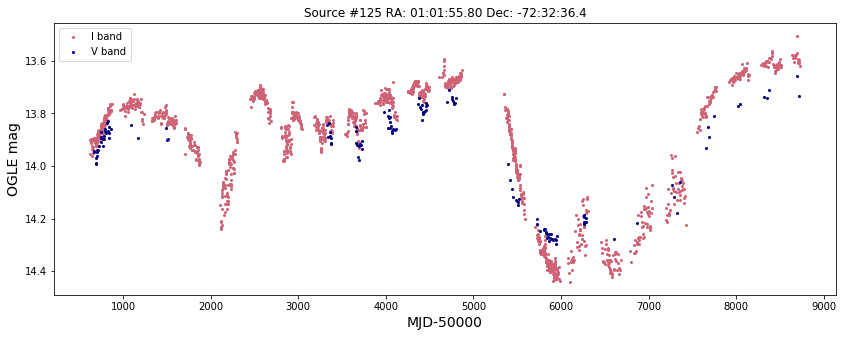

In [237]:
ilist,vlist = o.getIV(125,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
o.splinedetrend(iband,window=100)

In [238]:
summ[summ['src_n']==125]

src_n     ra_deg   dec_deg  spin period  perr  est. period       sep name  \
98    125  15.482444 -72.54349          0.0  0.58        36.41  0.456119  NaN   

       mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
98  13.917345  0.229582  ...             NaN          NaN   NaN  0.841697   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
98   -0.435593  0.639085   -0.968536           35.7893  1.0  0.299  

[1 rows x 45 columns]

(14.5, 13.5)

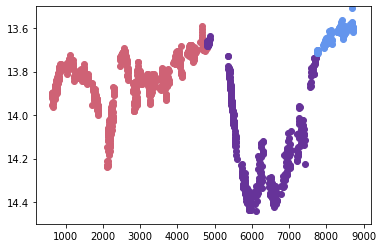

In [239]:
plt.scatter(iband['MJD-50000'][:1000],iband['I mag'][:1000],color=pink)
plt.scatter(iband['MJD-50000'][1000:1550],iband['I mag'][1000:1550],color=purple)
plt.scatter(iband['MJD-50000'][1550:],iband['I mag'][1550:],color=blue)
plt.ylim(14.5,13.5)

(14.2, 13.7)

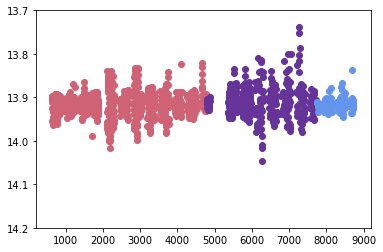

In [253]:
plt.scatter(iband['MJD-50000'][:1000],iband['I detrend'][:1000],color=pink)
plt.scatter(iband['MJD-50000'][1000:1550],iband['I detrend'][1000:1550],color=purple)
plt.scatter(iband['MJD-50000'][1550:],iband['I detrend'][1550:],color=blue)
plt.ylim(14.2,13.7)

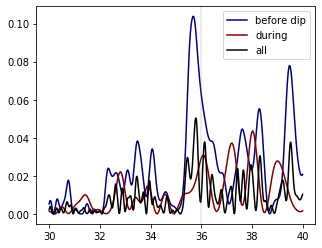

In [242]:
f1,p1,bp1 = o.periodogram(iband[:1000],minp=30,maxp=40,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[1000:1550],minp=30,maxp=40,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=30,maxp=40,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(36,color='grey',alpha=0.2)

In [250]:
bp4

<Quantity 35.78012995>

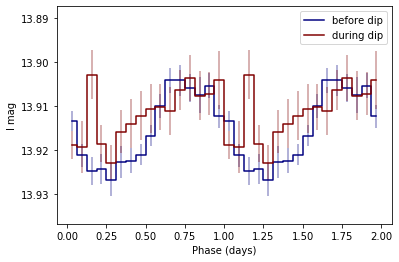

In [251]:
pd = bp4
o.phasestep(iband[:1000],pd,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1000:1550],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
# o.phasestep(iband[1550:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

agree with auto det pd

# 41

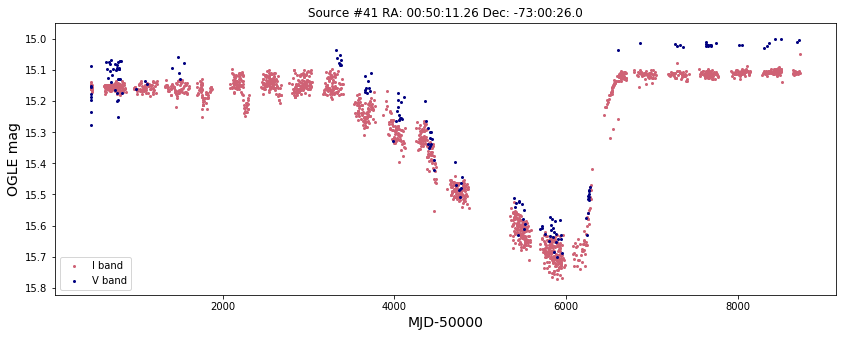

In [267]:
ilist,vlist = o.getIV(41,cross,stack=False,plot=True,figsize=(14,5))
iband = vstack(ilist)
o.splinedetrend(iband,window=400)

In [255]:
summ[summ['src_n']==41]

src_n     ra_deg    dec_deg  spin period  perr  est. period       sep  \
37     41  12.546373 -73.006966       214.03  0.53        29.91  1.581483   

   name    mean I   stdev I  ...  V-I transition  Type II amp  note    I skew  \
37  NaN  15.28044  0.208182  ...             NaN          NaN   NaN  1.044556   

    I kurtosis    V skew  V kurtosis  best auto det pd Part  I IQR  
37   -0.510886  0.485326   -1.277231         29.900176  1.0  0.324  

[1 rows x 45 columns]

(15.8, 15.0)

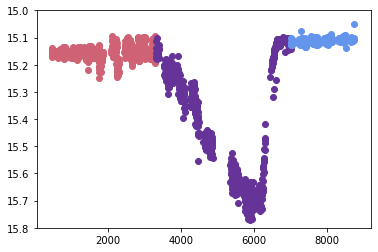

In [259]:
plt.scatter(iband['MJD-50000'][:700],iband['I mag'][:700],color=pink)
plt.scatter(iband['MJD-50000'][700:1550],iband['I mag'][700:1550],color=purple)
plt.scatter(iband['MJD-50000'][1550:],iband['I mag'][1550:],color=blue)
plt.ylim(15.8,15.0)

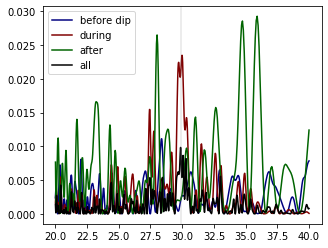

In [268]:
f1,p1,bp1 = o.periodogram(iband[:700],minp=20,maxp=40,more=True,plot=False,det=True)
f2,p2,bp2 = o.periodogram(iband[700:1550],minp=20,maxp=40,more=True,plot=False,det=True)
f3,p3,bp3 = o.periodogram(iband[1550:],minp=20,maxp=40,more=True,plot=False,det=True)
f4,p4,bp4 = o.periodogram(iband,minp=20,maxp=40,more=True,plot=False,det=True)

plt.figure(figsize=(5,4))
plt.plot(1/f1,p1,color='navy',label='before dip')
plt.plot(1/f2,p2,color='maroon',label='during')
plt.plot(1/f3,p3,color='darkgreen',label='after')
plt.plot(1/f4,p4,color='black',label='all')

plt.legend()
plt.axvline(29.9,color='grey',alpha=0.2)

In [261]:
bp2

<Quantity 29.98567854>

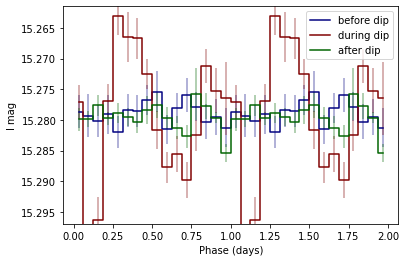

In [269]:
pd = 29.91
o.phasestep(iband[:700],pd,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[700:1550],pd,16,det=True,med=False,double=True,color='maroon',err=True,retall=False,epoch=0,sterr=True,divide=True,label='during dip')
o.phasestep(iband[1550:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.legend()

(15.287, 15.27)

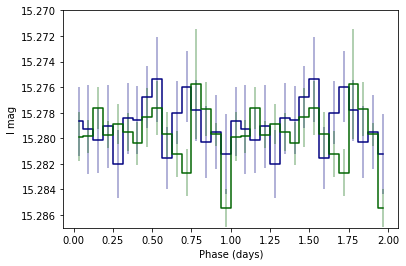

In [266]:
o.phasestep(iband[:700],pd,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1550:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
plt.ylim(15.287,15.27)

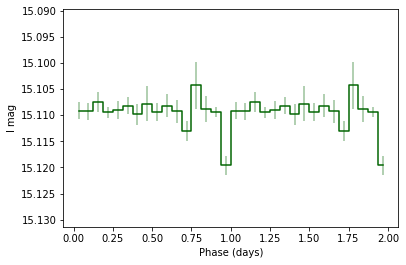

In [277]:
#without detrending -- identical profiles!
pd = 29.91
o.phasestep(iband[:700],pd,16,det=False,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1550:],pd,16,det=False,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
# plt.ylim(15.287,15.27)

29.87451229040241


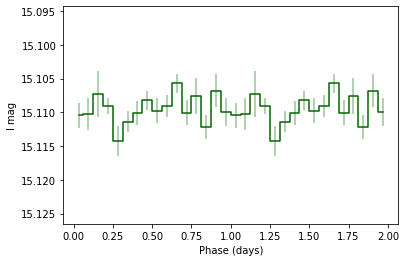

In [282]:
#without detrending -- identical profiles!
pd = bp4
print(pd)
o.phasestep(iband[:700],pd,16,det=False,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1550:],pd,16,det=False,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')
# plt.ylim(15.287,15.27)

strongest 29.91 day signal during dip  

28.383434533137507


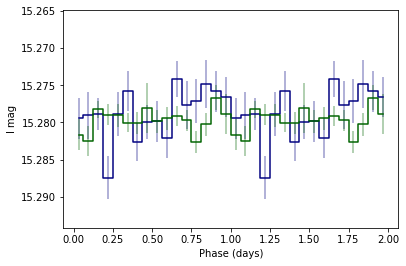

In [270]:
pd = bp1
print(pd)
o.phasestep(iband[:700],pd,16,det=True,med=False,double=True,color='navy',err=True,retall=False,epoch=0,sterr=True,divide=True,label='before dip')
o.phasestep(iband[1550:],pd,16,det=True,med=False,double=True,color='darkgreen',err=True,retall=False,epoch=0,sterr=True,divide=True,label='after dip')

# possible paramter for shapes of flares: ratio of 20% and 90% width for example

# automatically identify if super-orbital variation --> see if the phase-folded data is all worse
